In [ ]:
import re

file_path = '/content/drive/MyDrive/IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Ses01F_impro01.txt'

useful_regex = re.compile(r'\[.+\]\n', re.IGNORECASE)

with open(file_path) as f:
    file_content = f.read()
    
info_lines = re.findall(useful_regex, file_content)

for l in info_lines[1:10]:
    print(l.strip().split('\t'))

['[6.2901 - 8.2357]', 'Ses01F_impro01_F000', 'neu', '[2.5000, 2.5000, 2.5000]']
['[10.0100 - 11.3925]', 'Ses01F_impro01_F001', 'neu', '[2.5000, 2.5000, 2.5000]']
['[14.8872 - 18.0175]', 'Ses01F_impro01_F002', 'neu', '[2.5000, 2.5000, 2.5000]']
['[19.2900 - 20.7875]', 'Ses01F_impro01_F003', 'xxx', '[2.5000, 3.0000, 3.0000]']
['[21.3257 - 24.7400]', 'Ses01F_impro01_F004', 'xxx', '[2.5000, 3.0000, 2.5000]']
['[27.4600 - 31.4900]', 'Ses01F_impro01_F005', 'neu', '[2.5000, 3.5000, 2.0000]']
['[38.9650 - 43.5900]', 'Ses01F_impro01_F006', 'fru', '[2.0000, 3.5000, 3.5000]']
['[46.5800 - 52.1900]', 'Ses01F_impro01_F007', 'fru', '[2.5000, 3.5000, 3.5000]']
['[56.1600 - 58.8225]', 'Ses01F_impro01_F008', 'fru', '[2.0000, 3.5000, 3.5000]']


In [ ]:
import os

info_line = re.compile(r'\[.+\]\n', re.IGNORECASE)

start_times, end_times, wav_file_names, emotions, vals, acts, doms = [], [], [], [], [], [], []

for sess in range(1, 6):
    emo_evaluation_dir = '/content/drive/MyDrive/IEMOCAP_full_release/Session{}/dialog/EmoEvaluation/'.format(sess)
    evaluation_files = [l for l in os.listdir(emo_evaluation_dir) if 'Ses' in l]
    for file in evaluation_files:
        with open(emo_evaluation_dir + file) as f:
            content = f.read()
        info_lines = re.findall(info_line, content)
        for line in info_lines[1:]: 
            start_end_time, wav_file_name, emotion, val_act_dom = line.strip().split('\t')
            start_time, end_time = start_end_time[1:-1].split('-')
            val, act, dom = val_act_dom[1:-1].split(',')
            val, act, dom = float(val), float(act), float(dom)
            start_time, end_time = float(start_time), float(end_time)
            start_times.append(start_time)
            end_times.append(end_time)
            wav_file_names.append(wav_file_name)
            emotions.append(emotion)
            vals.append(val)
            acts.append(act)
            doms.append(dom)



import pandas as pd


df_iemocap = pd.DataFrame(columns=['start_time', 'end_time', 'wav_file', 'emotion', 'val', 'act', 'dom'])

df_iemocap['start_time'] = start_times
df_iemocap['end_time'] = end_times
df_iemocap['wav_file'] = wav_file_names
df_iemocap['emotion'] = emotions
df_iemocap['val'] = vals
df_iemocap['act'] = acts
df_iemocap['dom'] = doms

df_iemocap.tail()

start_time  end_time                wav_file emotion  val  act  dom
10034    246.7880  254.7300  Ses05F_script02_1_M030     exc  4.5  3.5  2.5
10035    254.7600  270.4256  Ses05F_script02_1_M031     exc  3.5  3.5  2.5
10036    270.4494  281.1720  Ses05F_script02_1_M032     exc  4.0  4.0  2.5
10037    281.2197  310.2662  Ses05F_script02_1_M033     exc  4.5  4.0  3.0
10038    310.9000  315.2200  Ses05F_script02_1_M034     exc  4.0  3.5  1.5

In [ ]:
df_iemocap["emotion"].value_counts()

xxx    2507
fru    1849
neu    1708
ang    1103
sad    1084
exc    1041
hap     595
sur     107
fea      40
oth       3
dis       2
Name: emotion, dtype: int64

In [ ]:
df_iemocap.to_csv('/content/drive/MyDrive/Preprocessing/df_iemocap.csv', index=False)

In [ ]:
df_iemocap.shape

(10039, 7)

In [ ]:
import librosa
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import pickle
import random

import IPython.display
import librosa.display
import time
import joblib
from joblib import Parallel, delayed
ms.use('seaborn-muted')
%matplotlib inline

In [ ]:
import pandas as pd
import math

labels_df = pd.read_csv('/content/drive/MyDrive/Preprocessing/df_iemocap.csv')
iemocap_dir = '/content/drive/MyDrive/IEMOCAP_full_release/'
save_dir = '/content/drive/MyDrive/Preprocessing/'
audio_vectors_path= save_dir + 'audio_vectors_'

In [ ]:
sr = 44100
audio_vectors = {}
for sess in range(1, 6):
    wav_file_path = '{}Session{}/dialog/wav/'.format(iemocap_dir, sess)
    forig_wav_files = os.listdir(wav_file_path)
    for forig_wav_file in tqdm(forig_wav_files):
        orig_wav_files = os.listdir(wav_file_path + forig_wav_file)
        for orig_wav_file in tqdm(orig_wav_files):
            try:
                #print(wav_file_path + forig_wav_file + '/' + orig_wav_file)
                orig_wav_vector, _sr = librosa.load(wav_file_path + forig_wav_file + '/' + orig_wav_file, sr=sr)
                orig_wav_file, file_format = orig_wav_file.split('.')
                for index, row in labels_df[labels_df['wav_file'].str.contains(orig_wav_file)].iterrows():
                    start_time, end_time, truncated_wav_file_name, emotion, val, act, dom = row['start_time'], row['end_time'], row['wav_file'], row['emotion'], row['val'], row['act'], row['dom']
                    start_frame = math.floor(start_time * sr)
                    end_frame = math.floor(end_time * sr)
                    truncated_wav_vector = orig_wav_vector[start_frame:end_frame + 1]
                    audio_vectors[truncated_wav_file_name] = truncated_wav_vector
            except:
                print('An exception occured for {}'.format(orig_wav_file))
        
    with open(save_dir + 'audio_vectors_{}.pkl'.format(sess), 'wb') as f:
        pickle.dump(audio_vectors, f)

 89%|████████▉ | 68/76 [00:16<00:02,  3.17it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")

 92%|█████████▏| 70/76 [00:17<00:01,  3.97it/s]

An exception occured for Ses01F_script01_3_F025.pk



 40%|████      | 37/92 [00:24<00:31,  1.76it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")

 41%|████▏     | 38/92 [00:25<00:34,  1.56it/s]

An exception occured for Ses02M_script03_2_F041.pk



 20%|██        | 15/75 [00:08<00:27,  2.19it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")

 21%|██▏       | 16/75 [00:09<00:35,  1.66it/s]

An exception occured for Ses02F_impro07_F019.pk



 61%|██████    | 36/59 [00:29<00:17,  1.32it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")

 63%|██████▎   | 37/59 [00:30<00:18,  1.18it/s]

An exception occured for Ses04F_impro08_F011.pk



100%|██████████| 31/31 [30:01<00:00, 58.12s/it]


In [ ]:

def features(X, sample_rate):
    
    stft = np.abs(librosa.stft(X))
    
    pitches, magnitudes = librosa.piptrack(X, sr=sample_rate, S=stft, fmin=70, fmax=400)
    pitch = []
    for i in range(magnitudes.shape[1]):
        index = magnitudes[:, 1].argmax()
        pitch.append(pitches[index, i])
        
    pitch_tuning_offset = librosa.pitch_tuning(pitches)
    pitchmean = np.mean(pitch)
    pitchstd = np.std(pitch)
    pitchmax = np.max(pitch)
    pitchmin = np.min(pitch)
    
    cent = librosa.feature.spectral_centroid(y=X, sr=sample_rate)
    cent = cent / np.sum(cent)
    meancent = np.mean(cent)
    stdcent = np.std(cent)
    maxcent = np.max(cent)
    
    flatness = np.mean(librosa.feature.spectral_flatness(y=X))

    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=12).T, axis=0)
    
    mfccsstd = np.std(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=12).T, axis=0)
    
    mfccmax = np.max(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=12).T, axis=0)    
    
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)    

    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)    

    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)    

    zerocr = np.mean(librosa.feature.zero_crossing_rate(X))

    rms = librosa.feature.rms(X + 0.0001)[0]
    meanrms = np.mean(rms)
    stdrms = np.std(rms)
    maxrms = np.max(rms)
    
    y_harmonic = np.mean(librosa.effects.hpss(X)[0])
    sig_mean = np.mean(abs(X))
    sig_std = np.std(X)

    ext_features = np.array([
        flatness, zerocr, meancent, stdcent,
        maxcent, pitchmean, pitchmax, pitchmin, pitchstd,
        pitch_tuning_offset, meanrms, maxrms, stdrms, y_harmonic, sig_mean, sig_std])

    
    ext_features = np.concatenate((ext_features, mfccs, mfccsstd, mfccmax, chroma, mel, contrast))
    
    return ext_features

In [ ]:
import soundfile as sf
from IPython.display import Audio

In [ ]:
labels_df = pd.read_csv('/content/drive/MyDrive/Preprocessing/df_iemocap.csv')
save_dir = '/content/drive/MyDrive/Preprocessing/'
audio_vectors_path = save_dir + 'audio_vectors_'

sess = 1

audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))

y1 = audio_vectors['Ses01F_impro07_M019']  # Happy
y2 = audio_vectors['Ses01F_impro06_F012']  # Sad
y3 = audio_vectors['Ses01F_script03_2_F025']  # Angry 
y4 = audio_vectors['Ses01F_script03_2_F031']  # Neutral

sr = 22050
print(audio_vectors)

Audio(y1, rate=sr)

In [ ]:
columns = ['wav_file', 'label', "flatness", "zerocr", "meancent", "stdcent", "maxcent", "pitchmean", 
           "pitchmax", "pitchmin", "pitchstd", "pitch_tuning_offset", "meanrms", "maxrms", "stdrms", 
           "y_harmonic", "sig_mean", "sig_std"]
columns_new = columns + [(lambda x: "mfcc_" + str(x))(x) for x in range(1, 13)] + [(lambda x: "mfccstd_" + str(x))(x) for x in range(1, 13)] + [(lambda x: "mfccmax_" + str(x))(x) for x in range(1, 13)] + [(lambda x: "chroma" + str(x))(x) for x in range(1, 13)] + [(lambda x: "mel" + str(x))(x) for x in range(1, 129)] + [(lambda x: "contrast" + str(x))(x) for x in range(1, 8)]

In [ ]:
df_features = pd.DataFrame(columns=columns_new)

emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8,
                'dis': 8}

labels_df.emotion.value_counts()

xxx    2507
fru    1849
neu    1708
ang    1103
sad    1084
exc    1041
hap     595
sur     107
fea      40
oth       3
dis       2
Name: emotion, dtype: int64

In [ ]:
for sess in range(1, 6):
    audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))
    for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):

        wav_file_name = row['wav_file']
    
        label = emotion_dict[row['emotion']]
        y = audio_vectors[wav_file_name]

        features_all = list(features(y, sr))
        
        feature_list = [wav_file_name, label] + features_all
        
        df_features = df_features.append(pd.DataFrame(feature_list, index=columns_new).transpose(), ignore_index=True)
        
    print("Session Finished {}".format(sess))

In [ ]:
df_features.to_csv('/content/drive/MyDrive/Preprocessing/audio_features.csv', index=False)

In [ ]:
import soundfile as sf
import random


data_dir = '/content/drive/MyDrive/Preprocessing/'
labels_df_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_1.pkl'.format(data_dir)

labels_df = pd.read_csv(labels_df_path)
audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))

random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]

y = audio_vectors[random_file_name]
print(audio_vectors)

sr = 44100

plt.figure(figsize=(15,2))
librosa.display.waveplot(y, sr=sr, max_sr=1000, alpha=0.25, color='r')

from IPython.display import Audio
Audio(y, rate=44100)

In [ ]:
columns = ['wav_file', 'label', 'sig_mean', 'sig_std']
df_features = pd.DataFrame(columns=columns)

emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8}

data_dir = '/content/drive/MyDrive/Preprocessing/'
labels_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_'.format(data_dir)

labels_df = pd.read_csv(labels_path)

for sess in (range(1, 6)):
        audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))
        for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):
            try:
                wav_file_name = row['wav_file']
                label = emotion_dict[row['emotion']]
                y = audio_vectors[wav_file_name]

                feature_list = [wav_file_name, label]
                sig_mean = np.mean(abs(y))
                feature_list.append(sig_mean)
                feature_list.append(np.std(y))

                df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
            except:
                print('Some exception occured')

df_features.to_csv('/content/drive/MyDrive/Preprocessing/audio_features.csv', index=False)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
1381it [00:01, 693.92it/s]

Some exception occured


1819it [00:02, 699.05it/s]
1811it [00:02, 664.45it/s]
396it [00:00, 655.98it/s]

Some exception occured


2136it [00:03, 645.02it/s]
2103it [00:03, 635.71it/s]
2170it [00:03, 642.68it/s]


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display

%matplotlib inline


df = pd.read_csv('/content/drive/MyDrive/Preprocessing/audio_features.csv')
df = df[df['label'].isin([0, 1, 2, 3, 4, 5, 6, 7])]
print(df.shape)
display(df.head())

# change 7 to 2
df['label'] = df['label'].map({0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 4, 7: 5})
df.head()

(7527, 4)


wav_file  label  sig_mean   sig_std
0  Ses01F_script03_2_F000      1  0.003597  0.004952
1  Ses01F_script03_2_F001      1       NaN       NaN
2  Ses01F_script03_2_F002      1       NaN       NaN
4  Ses01F_script03_2_F004      7       NaN       NaN
5  Ses01F_script03_2_F005      7       NaN       NaN

wav_file  label  sig_mean   sig_std
0  Ses01F_script03_2_F000      1  0.003597  0.004952
1  Ses01F_script03_2_F001      1       NaN       NaN
2  Ses01F_script03_2_F002      1       NaN       NaN
4  Ses01F_script03_2_F004      5       NaN       NaN
5  Ses01F_script03_2_F005      5       NaN       NaN

In [2]:
df.to_csv('/content/drive/MyDrive/Preprocessing/no_sample_df.csv')

fear_df = df[df['label']==3]
for i in range(30):
    df = df.append(fear_df)

sur_df = df[df['label']==4]
for i in range(10):
    df = df.append(sur_df)
    
df.to_csv('/content/drive/MyDrive/Preprocessing/modified_df.csv')

emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'neu': 3,}

scalar = MinMaxScaler()
df[df.columns[2:]] = scalar.fit_transform(df[df.columns[2:]])
df.head()

wav_file  label  sig_mean   sig_std
0  Ses01F_script03_2_F000      1  0.016673  0.012695
1  Ses01F_script03_2_F001      1       NaN       NaN
2  Ses01F_script03_2_F002      1       NaN       NaN
4  Ses01F_script03_2_F004      5       NaN       NaN
5  Ses01F_script03_2_F005      5       NaN       NaN

In [3]:
x_train, x_test = train_test_split(df, test_size=0.20)

x_train.to_csv('/content/drive/MyDrive/Preprocessing/audio_train.csv', index=False)
x_test.to_csv('/content/drive/MyDrive/Preprocessing/audio_test.csv', index=False)

print(x_train.shape, x_test.shape)

(7837, 4) (1960, 4)


In [4]:
x_train = pd.read_csv('/content/drive/MyDrive/Preprocessing/audio_train.csv')
x_test = pd.read_csv('/content/drive/MyDrive/Preprocessing/audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

(7837, 4)


In [5]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(7837, 4) (1960, 4)
{2: 2340, 5: 1352, 1: 1288, 3: 1001, 4: 966, 0: 890}


In [8]:
from sklearn import tree
from sklearn.dummy import DummyClassifier


print(x_train.shape)
print(x_test.shape)
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(x_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(x_test)
dummy_clf.score(x_test, y_test)

(7837, 2)
(1960, 2)


0.186734693877551

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
clf.predict(x_test)
clf.score(x_test, y_test)

In [ ]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
print(lb.classes_)
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_train.shape

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(layers.Conv1D(64, kernel_size=(8), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=(6)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(8),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=(6)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(256, kernel_size=(5),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=(1)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001),metrics=['accuracy'])

model.summary()

In [ ]:
checkpoint = ModelCheckpoint("best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history = model.fit(X_train, y_train,batch_size=64, epochs=180, validation_data=(X_test, y_test),callbacks=[checkpoint])

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

In [ ]:
predictions = model.predict(X_test)
predictions=predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

finaldf = actual.join(predictions)
finaldf[140:160]

In [ ]:
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [11]:
from __future__ import print_function
import numpy as np 
import pandas as pd 
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import IPython.display as ipd
import seaborn as sns

import warnings
import os
warnings.filterwarnings('ignore')

from torch import nn, optim
from torchvision import transforms, models, datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
data_dir = '/content/drive/MyDrive/spectrograms'
model_save_path = '/content/drive/MyDrive/saved_models'
train_dir = data_dir + '/Train'
test_dir = data_dir + '/Test'

In [13]:
batch_size = 64

In [14]:
train_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
test_transforms = transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [15]:
trainset = datasets.ImageFolder(train_dir,transform=train_transforms)
testset = datasets.ImageFolder(test_dir,transform=test_transforms)

In [16]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [17]:
print(len(testloader.dataset))

871


In [18]:
print(len(trainloader.dataset))

3482


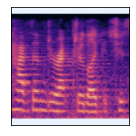

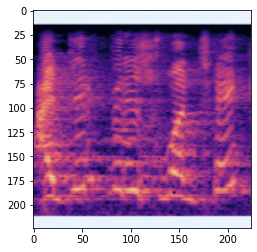

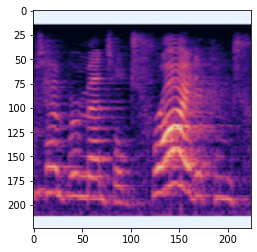

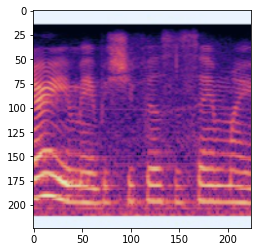

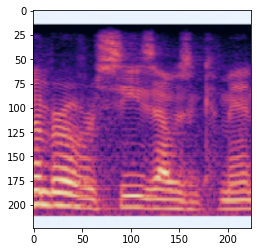

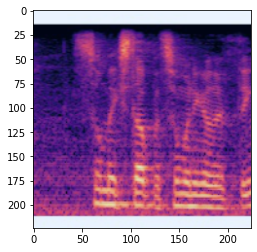

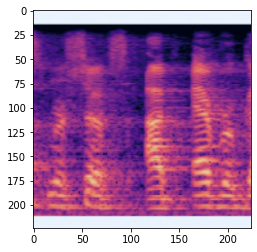

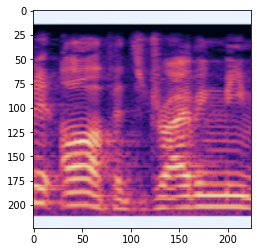

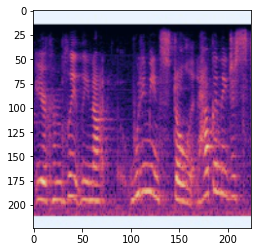

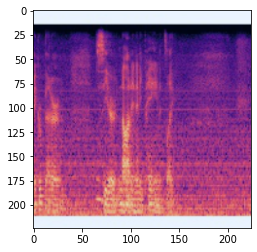

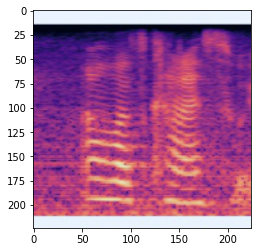

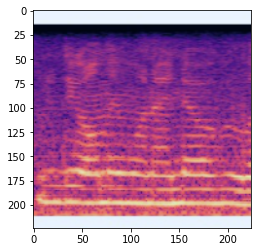

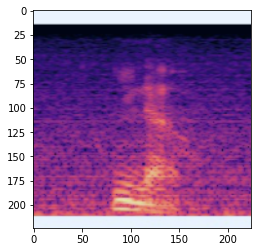

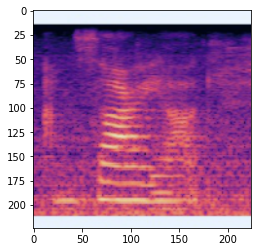

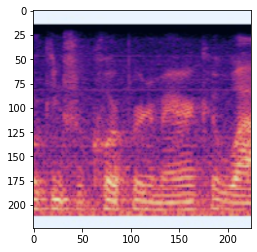

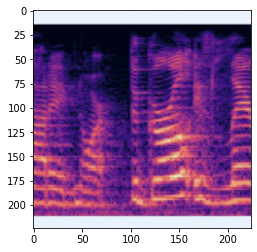

In [19]:
def scale(x):
    return (x - np.min(x))/np.ptp(x)

def imshow(img):
    img = scale(img)
#     print(img)
    plt.imshow(np.transpose(img, (1,2,0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(20,5))

for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    plt.show()

In [20]:
trainiter = iter(trainloader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [21]:
torch.cuda.is_available()

True

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [23]:
print(trainloader.dataset.class_to_idx)

{'anger': 0, 'happiness': 1, 'neutral': 2, 'sadness': 3}


In [24]:
anger = 0
happiness = 0
neutral = 0
sadness = 0

for _, target in trainloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])
    
for _, target in testloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])

In [25]:
print("anger {} happiness {} neutral {} sadness {}".format(anger, happiness, neutral, sadness))

anger 1075 happiness 590 neutral 1643 sadness 1045


In [26]:
sample_weights = [1/anger, 1/happiness, 1/neutral, 1/sadness]
class_weights = torch.FloatTensor(sample_weights).cuda()
class_weights

tensor([0.0009, 0.0017, 0.0006, 0.0010], device='cuda:0')

In [27]:
keep_prob = 0.5

In [28]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 224, 224, 3)
        #    Conv     -> (?, 224, 224, 16)
        #    Pool     -> (?, 112, 112, 16)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 112, 112, 16)
        #    Conv      ->(?, 112, 112, 32)
        #    Pool      ->(?, 56, 56, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 56, 56, 32)
        #    Conv      ->(?, 56, 56, 64)
        #    Pool      ->(?, 28, 28, 64)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        
        # L4 ImgIn shape=(?, 28, 28, 64)
        #    Conv      ->(?, 28, 28, 16)
        #    Pool      ->(?, 14, 14, 16)
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 16, kernel_size=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 14x14x16 inputs -> 512 outputs
        self.fc1 = torch.nn.Linear(14 * 14 * 16, 512, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
#         self.layer4 = torch.nn.Sequential(
#             self.fc1,
#             torch.nn.ReLU(),
#             torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 1024 inputs -> 512 outputs
        self.fc2 = torch.nn.Linear(512, 4, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters
        # L6 Final FC 512 inputs -> 4 outputs
#         self.fc3 = torch.nn.Linear(512, 4, bias=True)
#         torch.nn.init.xavier_uniform_(self.fc3.weight) # initialize parameters

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
#         print(out.size())
        out = out.view(out.size(0), -1)
#         print(out.size())# Flatten them for FC
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
#         out = self.fc3(out)
        return out

In [29]:
model = CNN()

In [30]:
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc1): Linear(in_features=3136, out_featur

In [31]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [32]:
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)

In [33]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

1,632,820 total parameters.
1,632,820 training parameters.


In [34]:
labels = list(trainloader.dataset.class_to_idx.keys())
labels

['anger', 'happiness', 'neutral', 'sadness']

In [35]:
def plot_confusion_matrix(actual, predicted, labels):
    cm = confusion_matrix(actual, predicted, labels)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, annot_kws={"size": 10}, fmt='.0f'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    plt.show()

In [36]:
label_to_class = {value: key for key, value in trainloader.dataset.class_to_idx.items()}
label_to_class

{0: 'anger', 1: 'happiness', 2: 'neutral', 3: 'sadness'}

In [37]:
def train(epoch, model):
    model.train()
    correct_train = 0
    train_loss = 0
    train_acc = 0
    
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        # zero the gradient, forward, backward and running pytorch rhythm
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct_train += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    
    train_loss /= len(trainloader.dataset)
    train_acc = 100. * correct_train / len(trainloader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(train_loss))
    print('\nTrain Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct_train, len(trainloader.dataset), 100. * correct_train / len(trainloader.dataset)))
    
    return train_loss, int(train_acc.numpy())

In [38]:
def test(model):
    model.eval()
    test_loss = 0
    test_acc = 0
    correct = 0
    history_test = []

    pred_model = []
    actual = []

    for data, target in testloader:
        data, target = data.to(device), target.to(device)

        # output from model
        output = model(data)

        # sum total loss
        test_loss += criterion(output, target).item()

        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        pred_model.append(pred.cpu().numpy())
        actual.append(target.data.cpu().numpy())


    test_loss /= len(testloader.dataset)
    test_acc = 100. * correct / len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


    pred_with_label = [label_to_class[label] for label in list(np.concatenate(pred_model))]
    actual_with_label = [label_to_class[label] for label in list(np.concatenate(actual))]

    plot_confusion_matrix(actual_with_label, pred_with_label, labels)

    print('\n Classification Report \n {} \n'.format(classification_report(actual_with_label, pred_with_label)))

    return test_loss, int(test_acc.numpy())

Train Epoch: 1 [0/3482 (0%)]	Loss: 1.758461

Train Epoch: 1 [640/3482 (18%)]	Loss: 1.606800

Train Epoch: 1 [1280/3482 (36%)]	Loss: 1.453336

Train Epoch: 1 [1920/3482 (55%)]	Loss: 1.397399

Train Epoch: 1 [2560/3482 (73%)]	Loss: 1.400588

Train Epoch: 1 [3200/3482 (91%)]	Loss: 1.437930


Train set: Average loss: 0.0232


Train Accuracy: 893/3482 (26%)


Test set: Average loss: 0.0224, Accuracy: 192/871 (22%)



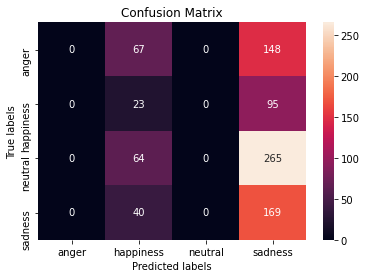


 Classification Report 
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       215
   happiness       0.12      0.19      0.15       118
     neutral       0.00      0.00      0.00       329
     sadness       0.25      0.81      0.38       209

    accuracy                           0.22       871
   macro avg       0.09      0.25      0.13       871
weighted avg       0.08      0.22      0.11       871
 

Train Epoch: 2 [0/3482 (0%)]	Loss: 1.357776

Train Epoch: 2 [640/3482 (18%)]	Loss: 1.366685

Train Epoch: 2 [1280/3482 (36%)]	Loss: 1.354268

Train Epoch: 2 [1920/3482 (55%)]	Loss: 1.399714

Train Epoch: 2 [2560/3482 (73%)]	Loss: 1.375791

Train Epoch: 2 [3200/3482 (91%)]	Loss: 1.375595


Train set: Average loss: 0.0218


Train Accuracy: 990/3482 (28%)


Test set: Average loss: 0.0223, Accuracy: 209/871 (24%)



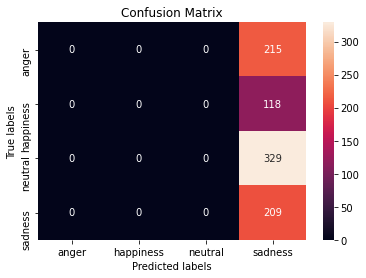


 Classification Report 
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       215
   happiness       0.00      0.00      0.00       118
     neutral       0.00      0.00      0.00       329
     sadness       0.24      1.00      0.39       209

    accuracy                           0.24       871
   macro avg       0.06      0.25      0.10       871
weighted avg       0.06      0.24      0.09       871
 

Train Epoch: 3 [0/3482 (0%)]	Loss: 1.359021

Train Epoch: 3 [640/3482 (18%)]	Loss: 1.372910

Train Epoch: 3 [1280/3482 (36%)]	Loss: 1.375557

Train Epoch: 3 [1920/3482 (55%)]	Loss: 1.350006

Train Epoch: 3 [2560/3482 (73%)]	Loss: 1.376338

Train Epoch: 3 [3200/3482 (91%)]	Loss: 1.390986


Train set: Average loss: 0.0217


Train Accuracy: 1053/3482 (30%)


Test set: Average loss: 0.0222, Accuracy: 209/871 (24%)



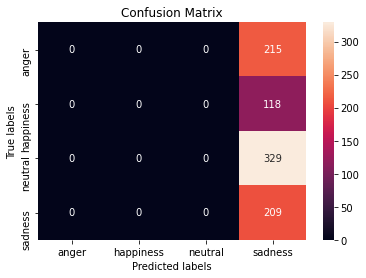


 Classification Report 
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       215
   happiness       0.00      0.00      0.00       118
     neutral       0.00      0.00      0.00       329
     sadness       0.24      1.00      0.39       209

    accuracy                           0.24       871
   macro avg       0.06      0.25      0.10       871
weighted avg       0.06      0.24      0.09       871
 

Train Epoch: 4 [0/3482 (0%)]	Loss: 1.433521

Train Epoch: 4 [640/3482 (18%)]	Loss: 1.406878

Train Epoch: 4 [1280/3482 (36%)]	Loss: 1.384230

Train Epoch: 4 [1920/3482 (55%)]	Loss: 1.308977

Train Epoch: 4 [2560/3482 (73%)]	Loss: 1.336980

Train Epoch: 4 [3200/3482 (91%)]	Loss: 1.339991


Train set: Average loss: 0.0214


Train Accuracy: 1126/3482 (32%)


Test set: Average loss: 0.0221, Accuracy: 209/871 (24%)



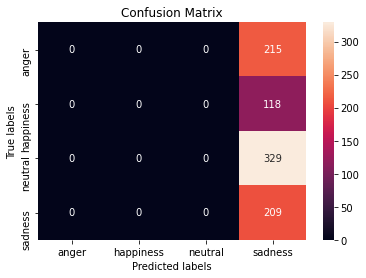


 Classification Report 
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       215
   happiness       0.00      0.00      0.00       118
     neutral       0.00      0.00      0.00       329
     sadness       0.24      1.00      0.39       209

    accuracy                           0.24       871
   macro avg       0.06      0.25      0.10       871
weighted avg       0.06      0.24      0.09       871
 

Train Epoch: 5 [0/3482 (0%)]	Loss: 1.371786

Train Epoch: 5 [640/3482 (18%)]	Loss: 1.361623

Train Epoch: 5 [1280/3482 (36%)]	Loss: 1.382068

Train Epoch: 5 [1920/3482 (55%)]	Loss: 1.287123

Train Epoch: 5 [2560/3482 (73%)]	Loss: 1.321790

Train Epoch: 5 [3200/3482 (91%)]	Loss: 1.321469


Train set: Average loss: 0.0211


Train Accuracy: 1252/3482 (36%)


Test set: Average loss: 0.0220, Accuracy: 211/871 (24%)



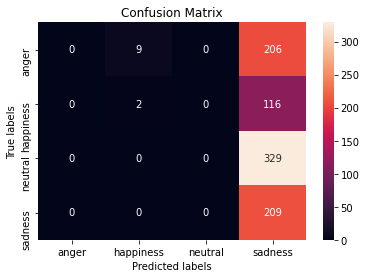


 Classification Report 
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       215
   happiness       0.18      0.02      0.03       118
     neutral       0.00      0.00      0.00       329
     sadness       0.24      1.00      0.39       209

    accuracy                           0.24       871
   macro avg       0.11      0.25      0.11       871
weighted avg       0.08      0.24      0.10       871
 

Train Epoch: 6 [0/3482 (0%)]	Loss: 1.365571

Train Epoch: 6 [640/3482 (18%)]	Loss: 1.319924

Train Epoch: 6 [1280/3482 (36%)]	Loss: 1.324986

Train Epoch: 6 [1920/3482 (55%)]	Loss: 1.292078

Train Epoch: 6 [2560/3482 (73%)]	Loss: 1.334025

Train Epoch: 6 [3200/3482 (91%)]	Loss: 1.322437


Train set: Average loss: 0.0206


Train Accuracy: 1300/3482 (37%)


Test set: Average loss: 0.0217, Accuracy: 238/871 (27%)



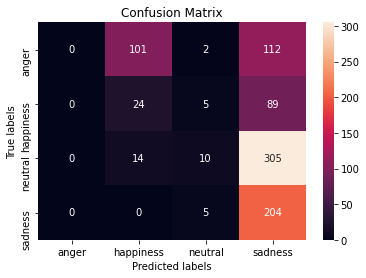


 Classification Report 
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       215
   happiness       0.17      0.20      0.19       118
     neutral       0.45      0.03      0.06       329
     sadness       0.29      0.98      0.44       209

    accuracy                           0.27       871
   macro avg       0.23      0.30      0.17       871
weighted avg       0.26      0.27      0.15       871
 

Train Epoch: 7 [0/3482 (0%)]	Loss: 1.334639

Train Epoch: 7 [640/3482 (18%)]	Loss: 1.271138

Train Epoch: 7 [1280/3482 (36%)]	Loss: 1.284917

Train Epoch: 7 [1920/3482 (55%)]	Loss: 1.343117

Train Epoch: 7 [2560/3482 (73%)]	Loss: 1.225625

Train Epoch: 7 [3200/3482 (91%)]	Loss: 1.277500


Train set: Average loss: 0.0201


Train Accuracy: 1396/3482 (40%)


Test set: Average loss: 0.0214, Accuracy: 266/871 (31%)



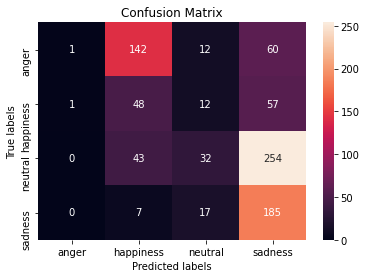


 Classification Report 
               precision    recall  f1-score   support

       anger       0.50      0.00      0.01       215
   happiness       0.20      0.41      0.27       118
     neutral       0.44      0.10      0.16       329
     sadness       0.33      0.89      0.48       209

    accuracy                           0.31       871
   macro avg       0.37      0.35      0.23       871
weighted avg       0.40      0.31      0.21       871
 

Train Epoch: 8 [0/3482 (0%)]	Loss: 1.335402

Train Epoch: 8 [640/3482 (18%)]	Loss: 1.155918

Train Epoch: 8 [1280/3482 (36%)]	Loss: 1.242954

Train Epoch: 8 [1920/3482 (55%)]	Loss: 1.283794

Train Epoch: 8 [2560/3482 (73%)]	Loss: 1.214388

Train Epoch: 8 [3200/3482 (91%)]	Loss: 1.217278


Train set: Average loss: 0.0197


Train Accuracy: 1460/3482 (42%)


Test set: Average loss: 0.0212, Accuracy: 287/871 (33%)



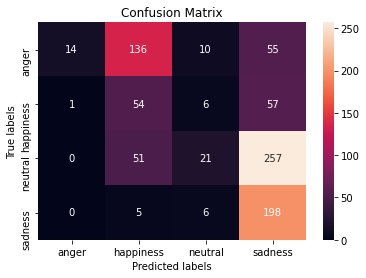


 Classification Report 
               precision    recall  f1-score   support

       anger       0.93      0.07      0.12       215
   happiness       0.22      0.46      0.30       118
     neutral       0.49      0.06      0.11       329
     sadness       0.35      0.95      0.51       209

    accuracy                           0.33       871
   macro avg       0.50      0.38      0.26       871
weighted avg       0.53      0.33      0.24       871
 

Train Epoch: 9 [0/3482 (0%)]	Loss: 1.221595

Train Epoch: 9 [640/3482 (18%)]	Loss: 1.216343

Train Epoch: 9 [1280/3482 (36%)]	Loss: 1.132260

Train Epoch: 9 [1920/3482 (55%)]	Loss: 1.167120

Train Epoch: 9 [2560/3482 (73%)]	Loss: 1.271415

Train Epoch: 9 [3200/3482 (91%)]	Loss: 1.332327


Train set: Average loss: 0.0192


Train Accuracy: 1517/3482 (44%)


Test set: Average loss: 0.0211, Accuracy: 301/871 (35%)



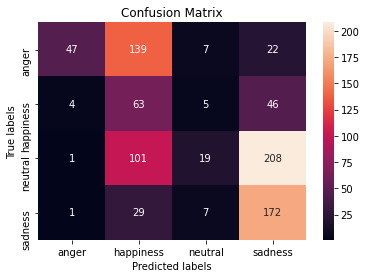


 Classification Report 
               precision    recall  f1-score   support

       anger       0.89      0.22      0.35       215
   happiness       0.19      0.53      0.28       118
     neutral       0.50      0.06      0.10       329
     sadness       0.38      0.82      0.52       209

    accuracy                           0.35       871
   macro avg       0.49      0.41      0.31       871
weighted avg       0.53      0.35      0.29       871
 

Train Epoch: 10 [0/3482 (0%)]	Loss: 1.263973

Train Epoch: 10 [640/3482 (18%)]	Loss: 1.128137

Train Epoch: 10 [1280/3482 (36%)]	Loss: 1.184293

Train Epoch: 10 [1920/3482 (55%)]	Loss: 1.214247

Train Epoch: 10 [2560/3482 (73%)]	Loss: 1.040112

Train Epoch: 10 [3200/3482 (91%)]	Loss: 1.220422


Train set: Average loss: 0.0190


Train Accuracy: 1555/3482 (45%)


Test set: Average loss: 0.0206, Accuracy: 349/871 (40%)



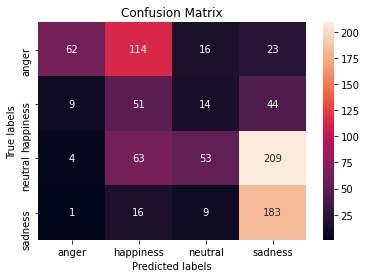


 Classification Report 
               precision    recall  f1-score   support

       anger       0.82      0.29      0.43       215
   happiness       0.21      0.43      0.28       118
     neutral       0.58      0.16      0.25       329
     sadness       0.40      0.88      0.55       209

    accuracy                           0.40       871
   macro avg       0.50      0.44      0.38       871
weighted avg       0.54      0.40      0.37       871
 

Train Epoch: 11 [0/3482 (0%)]	Loss: 1.131754

Train Epoch: 11 [640/3482 (18%)]	Loss: 1.213619

Train Epoch: 11 [1280/3482 (36%)]	Loss: 1.126823

Train Epoch: 11 [1920/3482 (55%)]	Loss: 1.163554

Train Epoch: 11 [2560/3482 (73%)]	Loss: 1.153576

Train Epoch: 11 [3200/3482 (91%)]	Loss: 1.095166


Train set: Average loss: 0.0189


Train Accuracy: 1582/3482 (45%)


Test set: Average loss: 0.0205, Accuracy: 355/871 (41%)



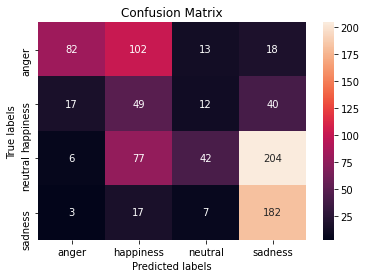


 Classification Report 
               precision    recall  f1-score   support

       anger       0.76      0.38      0.51       215
   happiness       0.20      0.42      0.27       118
     neutral       0.57      0.13      0.21       329
     sadness       0.41      0.87      0.56       209

    accuracy                           0.41       871
   macro avg       0.48      0.45      0.39       871
weighted avg       0.53      0.41      0.37       871
 

Train Epoch: 12 [0/3482 (0%)]	Loss: 1.084245

Train Epoch: 12 [640/3482 (18%)]	Loss: 1.280041

Train Epoch: 12 [1280/3482 (36%)]	Loss: 1.230015

Train Epoch: 12 [1920/3482 (55%)]	Loss: 1.247301

Train Epoch: 12 [2560/3482 (73%)]	Loss: 1.088010

Train Epoch: 12 [3200/3482 (91%)]	Loss: 1.010116


Train set: Average loss: 0.0187


Train Accuracy: 1547/3482 (44%)


Test set: Average loss: 0.0204, Accuracy: 392/871 (45%)



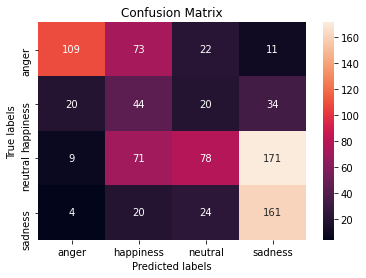


 Classification Report 
               precision    recall  f1-score   support

       anger       0.77      0.51      0.61       215
   happiness       0.21      0.37      0.27       118
     neutral       0.54      0.24      0.33       329
     sadness       0.43      0.77      0.55       209

    accuracy                           0.45       871
   macro avg       0.49      0.47      0.44       871
weighted avg       0.53      0.45      0.44       871
 

Train Epoch: 13 [0/3482 (0%)]	Loss: 1.126051

Train Epoch: 13 [640/3482 (18%)]	Loss: 1.173879

Train Epoch: 13 [1280/3482 (36%)]	Loss: 1.286390

Train Epoch: 13 [1920/3482 (55%)]	Loss: 1.165745

Train Epoch: 13 [2560/3482 (73%)]	Loss: 1.084281

Train Epoch: 13 [3200/3482 (91%)]	Loss: 1.162007


Train set: Average loss: 0.0184


Train Accuracy: 1664/3482 (48%)


Test set: Average loss: 0.0204, Accuracy: 394/871 (45%)



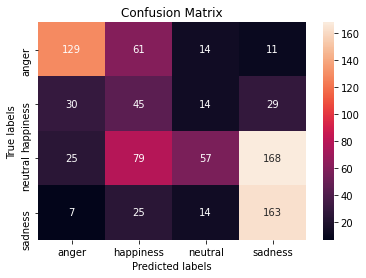


 Classification Report 
               precision    recall  f1-score   support

       anger       0.68      0.60      0.64       215
   happiness       0.21      0.38      0.27       118
     neutral       0.58      0.17      0.27       329
     sadness       0.44      0.78      0.56       209

    accuracy                           0.45       871
   macro avg       0.48      0.48      0.43       871
weighted avg       0.52      0.45      0.43       871
 

Train Epoch: 14 [0/3482 (0%)]	Loss: 1.176677

Train Epoch: 14 [640/3482 (18%)]	Loss: 1.215130

Train Epoch: 14 [1280/3482 (36%)]	Loss: 1.083235

Train Epoch: 14 [1920/3482 (55%)]	Loss: 1.060590

Train Epoch: 14 [2560/3482 (73%)]	Loss: 1.119658

Train Epoch: 14 [3200/3482 (91%)]	Loss: 1.167811


Train set: Average loss: 0.0182


Train Accuracy: 1672/3482 (48%)


Test set: Average loss: 0.0200, Accuracy: 400/871 (46%)



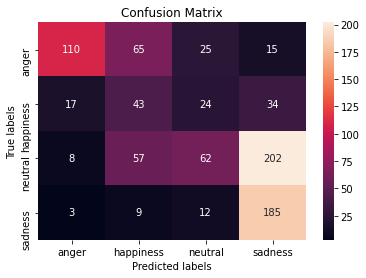


 Classification Report 
               precision    recall  f1-score   support

       anger       0.80      0.51      0.62       215
   happiness       0.25      0.36      0.29       118
     neutral       0.50      0.19      0.27       329
     sadness       0.42      0.89      0.57       209

    accuracy                           0.46       871
   macro avg       0.49      0.49      0.44       871
weighted avg       0.52      0.46      0.44       871
 

Train Epoch: 15 [0/3482 (0%)]	Loss: 1.095037

Train Epoch: 15 [640/3482 (18%)]	Loss: 1.202216

Train Epoch: 15 [1280/3482 (36%)]	Loss: 1.189856

Train Epoch: 15 [1920/3482 (55%)]	Loss: 1.100572

Train Epoch: 15 [2560/3482 (73%)]	Loss: 1.132086

Train Epoch: 15 [3200/3482 (91%)]	Loss: 1.222980


Train set: Average loss: 0.0181


Train Accuracy: 1695/3482 (49%)


Test set: Average loss: 0.0201, Accuracy: 430/871 (49%)



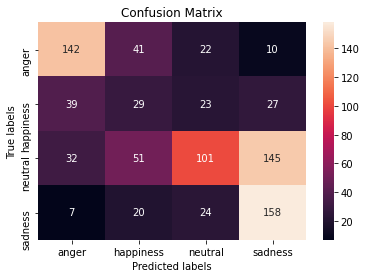


 Classification Report 
               precision    recall  f1-score   support

       anger       0.65      0.66      0.65       215
   happiness       0.21      0.25      0.22       118
     neutral       0.59      0.31      0.40       329
     sadness       0.46      0.76      0.58       209

    accuracy                           0.49       871
   macro avg       0.48      0.49      0.46       871
weighted avg       0.52      0.49      0.48       871
 

Train Epoch: 16 [0/3482 (0%)]	Loss: 1.105711

Train Epoch: 16 [640/3482 (18%)]	Loss: 1.177434

Train Epoch: 16 [1280/3482 (36%)]	Loss: 1.091996

Train Epoch: 16 [1920/3482 (55%)]	Loss: 1.138378

Train Epoch: 16 [2560/3482 (73%)]	Loss: 1.128854

Train Epoch: 16 [3200/3482 (91%)]	Loss: 1.016947


Train set: Average loss: 0.0178


Train Accuracy: 1713/3482 (49%)


Test set: Average loss: 0.0198, Accuracy: 434/871 (50%)



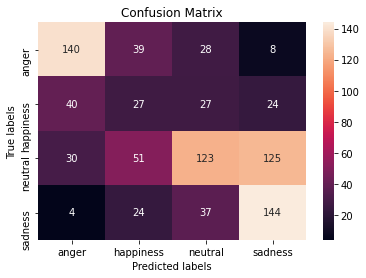


 Classification Report 
               precision    recall  f1-score   support

       anger       0.65      0.65      0.65       215
   happiness       0.19      0.23      0.21       118
     neutral       0.57      0.37      0.45       329
     sadness       0.48      0.69      0.56       209

    accuracy                           0.50       871
   macro avg       0.47      0.49      0.47       871
weighted avg       0.52      0.50      0.50       871
 

Train Epoch: 17 [0/3482 (0%)]	Loss: 1.118644

Train Epoch: 17 [640/3482 (18%)]	Loss: 1.320918

Train Epoch: 17 [1280/3482 (36%)]	Loss: 1.201913

Train Epoch: 17 [1920/3482 (55%)]	Loss: 1.068115

Train Epoch: 17 [2560/3482 (73%)]	Loss: 1.180453

Train Epoch: 17 [3200/3482 (91%)]	Loss: 1.121245


Train set: Average loss: 0.0178


Train Accuracy: 1717/3482 (49%)


Test set: Average loss: 0.0199, Accuracy: 437/871 (50%)



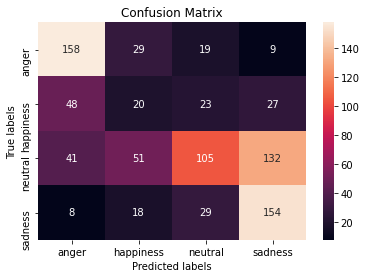


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.73      0.67       215
   happiness       0.17      0.17      0.17       118
     neutral       0.60      0.32      0.42       329
     sadness       0.48      0.74      0.58       209

    accuracy                           0.50       871
   macro avg       0.47      0.49      0.46       871
weighted avg       0.52      0.50      0.49       871
 

Train Epoch: 18 [0/3482 (0%)]	Loss: 1.062977

Train Epoch: 18 [640/3482 (18%)]	Loss: 1.248676

Train Epoch: 18 [1280/3482 (36%)]	Loss: 1.166890

Train Epoch: 18 [1920/3482 (55%)]	Loss: 1.179235

Train Epoch: 18 [2560/3482 (73%)]	Loss: 1.145360

Train Epoch: 18 [3200/3482 (91%)]	Loss: 1.070080


Train set: Average loss: 0.0177


Train Accuracy: 1732/3482 (50%)


Test set: Average loss: 0.0199, Accuracy: 461/871 (53%)



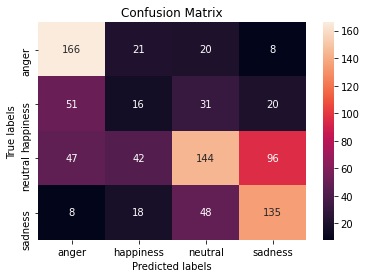


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.77      0.68       215
   happiness       0.16      0.14      0.15       118
     neutral       0.59      0.44      0.50       329
     sadness       0.52      0.65      0.58       209

    accuracy                           0.53       871
   macro avg       0.47      0.50      0.48       871
weighted avg       0.52      0.53      0.52       871
 

Train Epoch: 19 [0/3482 (0%)]	Loss: 1.082762

Train Epoch: 19 [640/3482 (18%)]	Loss: 1.171157

Train Epoch: 19 [1280/3482 (36%)]	Loss: 1.114804

Train Epoch: 19 [1920/3482 (55%)]	Loss: 0.998984

Train Epoch: 19 [2560/3482 (73%)]	Loss: 0.966551

Train Epoch: 19 [3200/3482 (91%)]	Loss: 1.100928


Train set: Average loss: 0.0178


Train Accuracy: 1748/3482 (50%)


Test set: Average loss: 0.0199, Accuracy: 442/871 (51%)



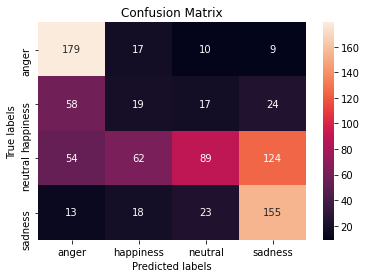


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.83      0.69       215
   happiness       0.16      0.16      0.16       118
     neutral       0.64      0.27      0.38       329
     sadness       0.50      0.74      0.60       209

    accuracy                           0.51       871
   macro avg       0.47      0.50      0.46       871
weighted avg       0.53      0.51      0.48       871
 

Train Epoch: 20 [0/3482 (0%)]	Loss: 1.065744

Train Epoch: 20 [640/3482 (18%)]	Loss: 1.204287

Train Epoch: 20 [1280/3482 (36%)]	Loss: 1.027436

Train Epoch: 20 [1920/3482 (55%)]	Loss: 1.279782

Train Epoch: 20 [2560/3482 (73%)]	Loss: 1.055693

Train Epoch: 20 [3200/3482 (91%)]	Loss: 1.154728


Train set: Average loss: 0.0174


Train Accuracy: 1728/3482 (50%)


Test set: Average loss: 0.0196, Accuracy: 467/871 (54%)



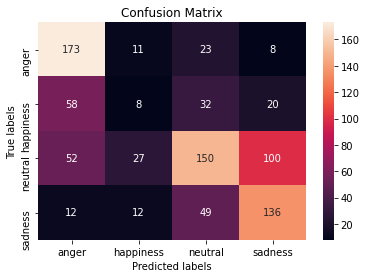


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.80      0.68       215
   happiness       0.14      0.07      0.09       118
     neutral       0.59      0.46      0.51       329
     sadness       0.52      0.65      0.58       209

    accuracy                           0.54       871
   macro avg       0.46      0.49      0.46       871
weighted avg       0.51      0.54      0.51       871
 

Train Epoch: 21 [0/3482 (0%)]	Loss: 1.022518

Train Epoch: 21 [640/3482 (18%)]	Loss: 0.992357

Train Epoch: 21 [1280/3482 (36%)]	Loss: 1.230688

Train Epoch: 21 [1920/3482 (55%)]	Loss: 1.071678

Train Epoch: 21 [2560/3482 (73%)]	Loss: 1.065244

Train Epoch: 21 [3200/3482 (91%)]	Loss: 1.097658


Train set: Average loss: 0.0174


Train Accuracy: 1798/3482 (52%)


Test set: Average loss: 0.0193, Accuracy: 461/871 (53%)



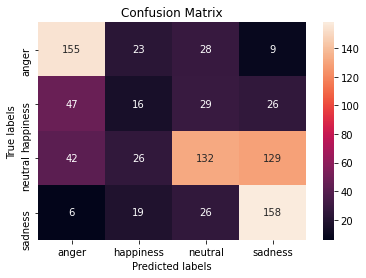


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.72      0.67       215
   happiness       0.19      0.14      0.16       118
     neutral       0.61      0.40      0.49       329
     sadness       0.49      0.76      0.60       209

    accuracy                           0.53       871
   macro avg       0.48      0.50      0.48       871
weighted avg       0.53      0.53      0.51       871
 

Train Epoch: 22 [0/3482 (0%)]	Loss: 1.094300

Train Epoch: 22 [640/3482 (18%)]	Loss: 1.140246

Train Epoch: 22 [1280/3482 (36%)]	Loss: 1.148655

Train Epoch: 22 [1920/3482 (55%)]	Loss: 1.103389

Train Epoch: 22 [2560/3482 (73%)]	Loss: 1.078938

Train Epoch: 22 [3200/3482 (91%)]	Loss: 1.099710


Train set: Average loss: 0.0174


Train Accuracy: 1778/3482 (51%)


Test set: Average loss: 0.0198, Accuracy: 450/871 (52%)



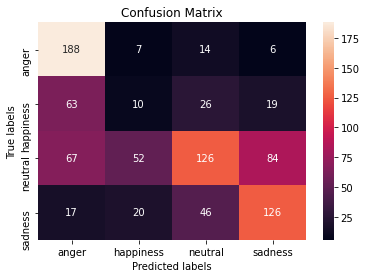


 Classification Report 
               precision    recall  f1-score   support

       anger       0.56      0.87      0.68       215
   happiness       0.11      0.08      0.10       118
     neutral       0.59      0.38      0.47       329
     sadness       0.54      0.60      0.57       209

    accuracy                           0.52       871
   macro avg       0.45      0.49      0.45       871
weighted avg       0.51      0.52      0.49       871
 

Train Epoch: 23 [0/3482 (0%)]	Loss: 1.064156

Train Epoch: 23 [640/3482 (18%)]	Loss: 1.257735

Train Epoch: 23 [1280/3482 (36%)]	Loss: 1.055848

Train Epoch: 23 [1920/3482 (55%)]	Loss: 1.041734

Train Epoch: 23 [2560/3482 (73%)]	Loss: 1.042517

Train Epoch: 23 [3200/3482 (91%)]	Loss: 1.224550


Train set: Average loss: 0.0174


Train Accuracy: 1803/3482 (52%)


Test set: Average loss: 0.0195, Accuracy: 459/871 (53%)



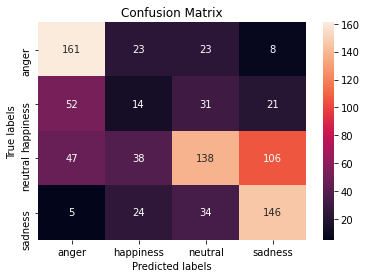


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.75      0.67       215
   happiness       0.14      0.12      0.13       118
     neutral       0.61      0.42      0.50       329
     sadness       0.52      0.70      0.60       209

    accuracy                           0.53       871
   macro avg       0.47      0.50      0.47       871
weighted avg       0.52      0.53      0.51       871
 

Train Epoch: 24 [0/3482 (0%)]	Loss: 1.073793

Train Epoch: 24 [640/3482 (18%)]	Loss: 1.043402

Train Epoch: 24 [1280/3482 (36%)]	Loss: 1.015059

Train Epoch: 24 [1920/3482 (55%)]	Loss: 0.989377

Train Epoch: 24 [2560/3482 (73%)]	Loss: 1.160207

Train Epoch: 24 [3200/3482 (91%)]	Loss: 1.045657


Train set: Average loss: 0.0174


Train Accuracy: 1812/3482 (52%)


Test set: Average loss: 0.0196, Accuracy: 446/871 (51%)



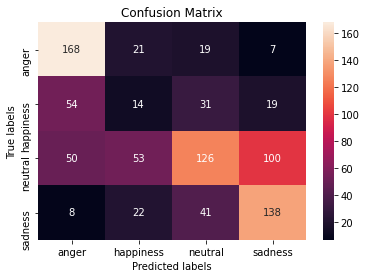


 Classification Report 
               precision    recall  f1-score   support

       anger       0.60      0.78      0.68       215
   happiness       0.13      0.12      0.12       118
     neutral       0.58      0.38      0.46       329
     sadness       0.52      0.66      0.58       209

    accuracy                           0.51       871
   macro avg       0.46      0.49      0.46       871
weighted avg       0.51      0.51      0.50       871
 

Train Epoch: 25 [0/3482 (0%)]	Loss: 1.086997

Train Epoch: 25 [640/3482 (18%)]	Loss: 0.941007

Train Epoch: 25 [1280/3482 (36%)]	Loss: 1.076593

Train Epoch: 25 [1920/3482 (55%)]	Loss: 1.039092

Train Epoch: 25 [2560/3482 (73%)]	Loss: 0.994539

Train Epoch: 25 [3200/3482 (91%)]	Loss: 1.100821


Train set: Average loss: 0.0172


Train Accuracy: 1806/3482 (52%)


Test set: Average loss: 0.0196, Accuracy: 438/871 (50%)



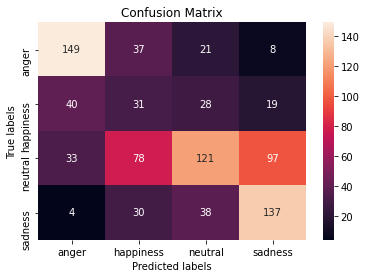


 Classification Report 
               precision    recall  f1-score   support

       anger       0.66      0.69      0.68       215
   happiness       0.18      0.26      0.21       118
     neutral       0.58      0.37      0.45       329
     sadness       0.52      0.66      0.58       209

    accuracy                           0.50       871
   macro avg       0.49      0.49      0.48       871
weighted avg       0.53      0.50      0.51       871
 

Train Epoch: 26 [0/3482 (0%)]	Loss: 1.178723

Train Epoch: 26 [640/3482 (18%)]	Loss: 1.197139

Train Epoch: 26 [1280/3482 (36%)]	Loss: 1.156619

Train Epoch: 26 [1920/3482 (55%)]	Loss: 1.084485

Train Epoch: 26 [2560/3482 (73%)]	Loss: 1.212843

Train Epoch: 26 [3200/3482 (91%)]	Loss: 1.052083


Train set: Average loss: 0.0173


Train Accuracy: 1780/3482 (51%)


Test set: Average loss: 0.0195, Accuracy: 449/871 (52%)



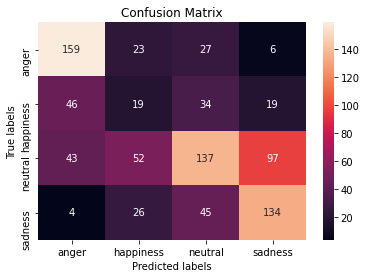


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.74      0.68       215
   happiness       0.16      0.16      0.16       118
     neutral       0.56      0.42      0.48       329
     sadness       0.52      0.64      0.58       209

    accuracy                           0.52       871
   macro avg       0.47      0.49      0.47       871
weighted avg       0.52      0.52      0.51       871
 

Train Epoch: 27 [0/3482 (0%)]	Loss: 1.023422

Train Epoch: 27 [640/3482 (18%)]	Loss: 1.034652

Train Epoch: 27 [1280/3482 (36%)]	Loss: 1.072889

Train Epoch: 27 [1920/3482 (55%)]	Loss: 1.090286

Train Epoch: 27 [2560/3482 (73%)]	Loss: 1.206016

Train Epoch: 27 [3200/3482 (91%)]	Loss: 1.153608


Train set: Average loss: 0.0171


Train Accuracy: 1849/3482 (53%)


Test set: Average loss: 0.0195, Accuracy: 449/871 (52%)



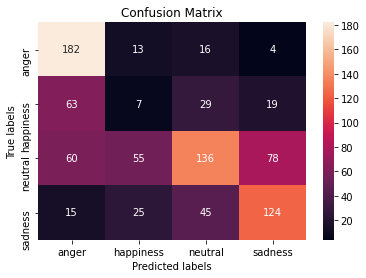


 Classification Report 
               precision    recall  f1-score   support

       anger       0.57      0.85      0.68       215
   happiness       0.07      0.06      0.06       118
     neutral       0.60      0.41      0.49       329
     sadness       0.55      0.59      0.57       209

    accuracy                           0.52       871
   macro avg       0.45      0.48      0.45       871
weighted avg       0.51      0.52      0.50       871
 

Train Epoch: 28 [0/3482 (0%)]	Loss: 0.948641

Train Epoch: 28 [640/3482 (18%)]	Loss: 1.192758

Train Epoch: 28 [1280/3482 (36%)]	Loss: 1.175649

Train Epoch: 28 [1920/3482 (55%)]	Loss: 1.083710

Train Epoch: 28 [2560/3482 (73%)]	Loss: 1.117483

Train Epoch: 28 [3200/3482 (91%)]	Loss: 1.111159


Train set: Average loss: 0.0171


Train Accuracy: 1833/3482 (53%)


Test set: Average loss: 0.0197, Accuracy: 431/871 (49%)



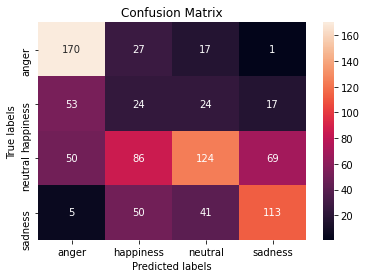


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.79      0.69       215
   happiness       0.13      0.20      0.16       118
     neutral       0.60      0.38      0.46       329
     sadness       0.56      0.54      0.55       209

    accuracy                           0.49       871
   macro avg       0.48      0.48      0.47       871
weighted avg       0.53      0.49      0.50       871
 

Train Epoch: 29 [0/3482 (0%)]	Loss: 1.025003

Train Epoch: 29 [640/3482 (18%)]	Loss: 1.190117

Train Epoch: 29 [1280/3482 (36%)]	Loss: 1.042862

Train Epoch: 29 [1920/3482 (55%)]	Loss: 1.180940

Train Epoch: 29 [2560/3482 (73%)]	Loss: 1.118407

Train Epoch: 29 [3200/3482 (91%)]	Loss: 1.135774


Train set: Average loss: 0.0171


Train Accuracy: 1832/3482 (53%)


Test set: Average loss: 0.0197, Accuracy: 438/871 (50%)



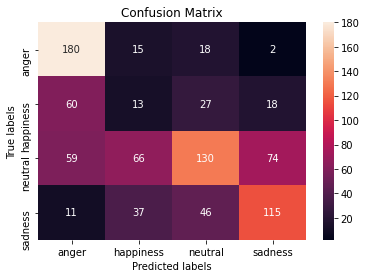


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.84      0.69       215
   happiness       0.10      0.11      0.10       118
     neutral       0.59      0.40      0.47       329
     sadness       0.55      0.55      0.55       209

    accuracy                           0.50       871
   macro avg       0.45      0.47      0.45       871
weighted avg       0.51      0.50      0.49       871
 

Train Epoch: 30 [0/3482 (0%)]	Loss: 1.199367

Train Epoch: 30 [640/3482 (18%)]	Loss: 0.975811

Train Epoch: 30 [1280/3482 (36%)]	Loss: 0.974464

Train Epoch: 30 [1920/3482 (55%)]	Loss: 1.123498

Train Epoch: 30 [2560/3482 (73%)]	Loss: 1.114286

Train Epoch: 30 [3200/3482 (91%)]	Loss: 1.040969


Train set: Average loss: 0.0169


Train Accuracy: 1842/3482 (53%)


Test set: Average loss: 0.0193, Accuracy: 435/871 (50%)



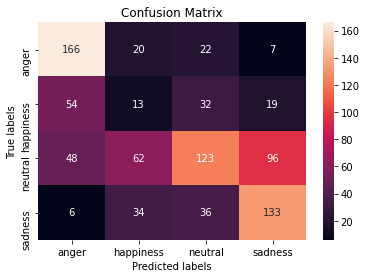


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.77      0.68       215
   happiness       0.10      0.11      0.11       118
     neutral       0.58      0.37      0.45       329
     sadness       0.52      0.64      0.57       209

    accuracy                           0.50       871
   macro avg       0.45      0.47      0.45       871
weighted avg       0.51      0.50      0.49       871
 

Train Epoch: 31 [0/3482 (0%)]	Loss: 1.166354

Train Epoch: 31 [640/3482 (18%)]	Loss: 0.983367

Train Epoch: 31 [1280/3482 (36%)]	Loss: 0.960187

Train Epoch: 31 [1920/3482 (55%)]	Loss: 1.107148

Train Epoch: 31 [2560/3482 (73%)]	Loss: 1.122702

Train Epoch: 31 [3200/3482 (91%)]	Loss: 1.209888


Train set: Average loss: 0.0170


Train Accuracy: 1849/3482 (53%)


Test set: Average loss: 0.0193, Accuracy: 453/871 (52%)



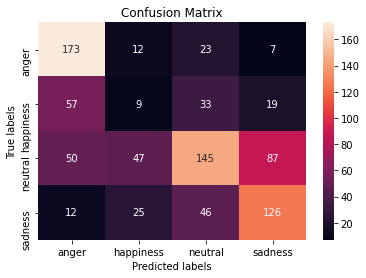


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.80      0.68       215
   happiness       0.10      0.08      0.09       118
     neutral       0.59      0.44      0.50       329
     sadness       0.53      0.60      0.56       209

    accuracy                           0.52       871
   macro avg       0.45      0.48      0.46       871
weighted avg       0.51      0.52      0.51       871
 

Train Epoch: 32 [0/3482 (0%)]	Loss: 0.890185

Train Epoch: 32 [640/3482 (18%)]	Loss: 1.097525

Train Epoch: 32 [1280/3482 (36%)]	Loss: 1.018607

Train Epoch: 32 [1920/3482 (55%)]	Loss: 1.039960

Train Epoch: 32 [2560/3482 (73%)]	Loss: 1.063743

Train Epoch: 32 [3200/3482 (91%)]	Loss: 0.997048


Train set: Average loss: 0.0169


Train Accuracy: 1856/3482 (53%)


Test set: Average loss: 0.0194, Accuracy: 437/871 (50%)



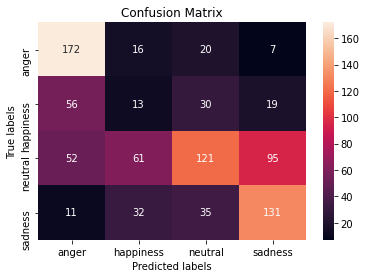


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.80      0.68       215
   happiness       0.11      0.11      0.11       118
     neutral       0.59      0.37      0.45       329
     sadness       0.52      0.63      0.57       209

    accuracy                           0.50       871
   macro avg       0.45      0.48      0.45       871
weighted avg       0.51      0.50      0.49       871
 

Train Epoch: 33 [0/3482 (0%)]	Loss: 0.955352

Train Epoch: 33 [640/3482 (18%)]	Loss: 1.062519

Train Epoch: 33 [1280/3482 (36%)]	Loss: 1.162612

Train Epoch: 33 [1920/3482 (55%)]	Loss: 1.079089

Train Epoch: 33 [2560/3482 (73%)]	Loss: 1.078435

Train Epoch: 33 [3200/3482 (91%)]	Loss: 1.021242


Train set: Average loss: 0.0170


Train Accuracy: 1832/3482 (53%)


Test set: Average loss: 0.0200, Accuracy: 398/871 (46%)



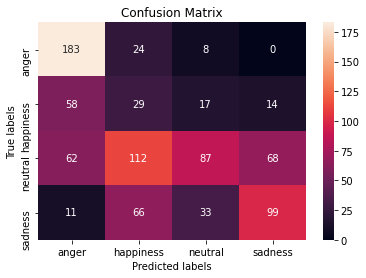


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.85      0.69       215
   happiness       0.13      0.25      0.17       118
     neutral       0.60      0.26      0.37       329
     sadness       0.55      0.47      0.51       209

    accuracy                           0.46       871
   macro avg       0.46      0.46      0.43       871
weighted avg       0.52      0.46      0.45       871
 

Train Epoch: 34 [0/3482 (0%)]	Loss: 1.070647

Train Epoch: 34 [640/3482 (18%)]	Loss: 1.046397

Train Epoch: 34 [1280/3482 (36%)]	Loss: 1.039317

Train Epoch: 34 [1920/3482 (55%)]	Loss: 1.110611

Train Epoch: 34 [2560/3482 (73%)]	Loss: 1.093038

Train Epoch: 34 [3200/3482 (91%)]	Loss: 1.012044


Train set: Average loss: 0.0170


Train Accuracy: 1854/3482 (53%)


Test set: Average loss: 0.0198, Accuracy: 423/871 (49%)



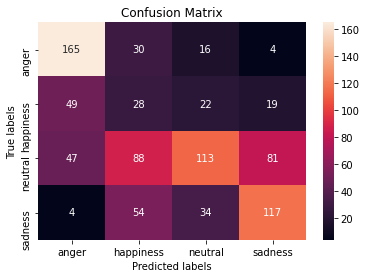


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.77      0.69       215
   happiness       0.14      0.24      0.18       118
     neutral       0.61      0.34      0.44       329
     sadness       0.53      0.56      0.54       209

    accuracy                           0.49       871
   macro avg       0.48      0.48      0.46       871
weighted avg       0.53      0.49      0.49       871
 

Train Epoch: 35 [0/3482 (0%)]	Loss: 1.144224

Train Epoch: 35 [640/3482 (18%)]	Loss: 0.972051

Train Epoch: 35 [1280/3482 (36%)]	Loss: 1.109780

Train Epoch: 35 [1920/3482 (55%)]	Loss: 1.166752

Train Epoch: 35 [2560/3482 (73%)]	Loss: 0.969878

Train Epoch: 35 [3200/3482 (91%)]	Loss: 0.945458


Train set: Average loss: 0.0169


Train Accuracy: 1880/3482 (54%)


Test set: Average loss: 0.0196, Accuracy: 427/871 (49%)



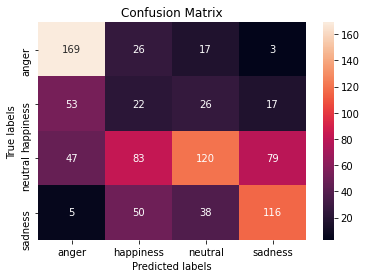


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.79      0.69       215
   happiness       0.12      0.19      0.15       118
     neutral       0.60      0.36      0.45       329
     sadness       0.54      0.56      0.55       209

    accuracy                           0.49       871
   macro avg       0.47      0.47      0.46       871
weighted avg       0.52      0.49      0.49       871
 

Train Epoch: 36 [0/3482 (0%)]	Loss: 1.078149

Train Epoch: 36 [640/3482 (18%)]	Loss: 1.033777

Train Epoch: 36 [1280/3482 (36%)]	Loss: 1.071956

Train Epoch: 36 [1920/3482 (55%)]	Loss: 1.165679

Train Epoch: 36 [2560/3482 (73%)]	Loss: 1.133911

Train Epoch: 36 [3200/3482 (91%)]	Loss: 1.101322


Train set: Average loss: 0.0170


Train Accuracy: 1861/3482 (53%)


Test set: Average loss: 0.0199, Accuracy: 418/871 (48%)



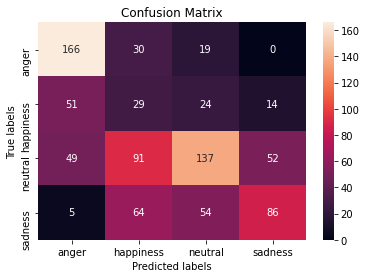


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.77      0.68       215
   happiness       0.14      0.25      0.17       118
     neutral       0.59      0.42      0.49       329
     sadness       0.57      0.41      0.48       209

    accuracy                           0.48       871
   macro avg       0.47      0.46      0.46       871
weighted avg       0.53      0.48      0.49       871
 

Train Epoch: 37 [0/3482 (0%)]	Loss: 1.094181

Train Epoch: 37 [640/3482 (18%)]	Loss: 1.024251

Train Epoch: 37 [1280/3482 (36%)]	Loss: 1.186299

Train Epoch: 37 [1920/3482 (55%)]	Loss: 1.081546

Train Epoch: 37 [2560/3482 (73%)]	Loss: 1.122053

Train Epoch: 37 [3200/3482 (91%)]	Loss: 0.986647


Train set: Average loss: 0.0170


Train Accuracy: 1886/3482 (54%)


Test set: Average loss: 0.0201, Accuracy: 390/871 (45%)



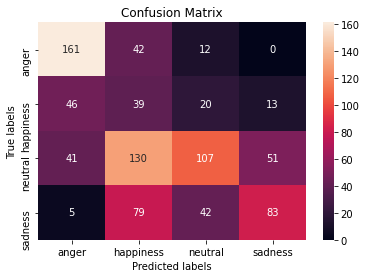


 Classification Report 
               precision    recall  f1-score   support

       anger       0.64      0.75      0.69       215
   happiness       0.13      0.33      0.19       118
     neutral       0.59      0.33      0.42       329
     sadness       0.56      0.40      0.47       209

    accuracy                           0.45       871
   macro avg       0.48      0.45      0.44       871
weighted avg       0.53      0.45      0.47       871
 

Train Epoch: 38 [0/3482 (0%)]	Loss: 1.234475

Train Epoch: 38 [640/3482 (18%)]	Loss: 0.957094

Train Epoch: 38 [1280/3482 (36%)]	Loss: 1.069996

Train Epoch: 38 [1920/3482 (55%)]	Loss: 1.103240

Train Epoch: 38 [2560/3482 (73%)]	Loss: 1.088767

Train Epoch: 38 [3200/3482 (91%)]	Loss: 1.074083


Train set: Average loss: 0.0170


Train Accuracy: 1854/3482 (53%)


Test set: Average loss: 0.0199, Accuracy: 420/871 (48%)



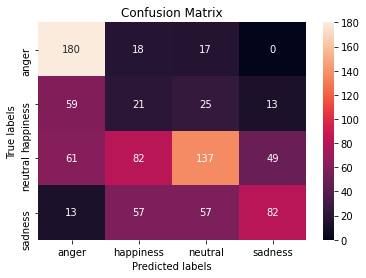


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.84      0.68       215
   happiness       0.12      0.18      0.14       118
     neutral       0.58      0.42      0.48       329
     sadness       0.57      0.39      0.46       209

    accuracy                           0.48       871
   macro avg       0.46      0.46      0.44       871
weighted avg       0.51      0.48      0.48       871
 

Train Epoch: 39 [0/3482 (0%)]	Loss: 0.929955

Train Epoch: 39 [640/3482 (18%)]	Loss: 1.194272

Train Epoch: 39 [1280/3482 (36%)]	Loss: 1.142475

Train Epoch: 39 [1920/3482 (55%)]	Loss: 1.106039

Train Epoch: 39 [2560/3482 (73%)]	Loss: 1.197131

Train Epoch: 39 [3200/3482 (91%)]	Loss: 1.018114


Train set: Average loss: 0.0168


Train Accuracy: 1841/3482 (53%)


Test set: Average loss: 0.0195, Accuracy: 434/871 (50%)



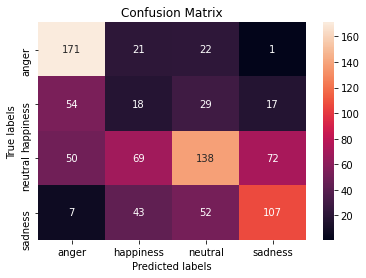


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.80      0.69       215
   happiness       0.12      0.15      0.13       118
     neutral       0.57      0.42      0.48       329
     sadness       0.54      0.51      0.53       209

    accuracy                           0.50       871
   macro avg       0.46      0.47      0.46       871
weighted avg       0.51      0.50      0.50       871
 

Train Epoch: 40 [0/3482 (0%)]	Loss: 0.969012

Train Epoch: 40 [640/3482 (18%)]	Loss: 1.059925

Train Epoch: 40 [1280/3482 (36%)]	Loss: 1.098136

Train Epoch: 40 [1920/3482 (55%)]	Loss: 1.025270

Train Epoch: 40 [2560/3482 (73%)]	Loss: 1.117004

Train Epoch: 40 [3200/3482 (91%)]	Loss: 1.033463


Train set: Average loss: 0.0169


Train Accuracy: 1915/3482 (55%)


Test set: Average loss: 0.0201, Accuracy: 388/871 (45%)



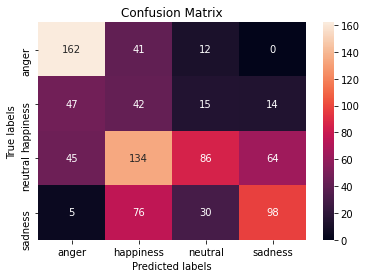


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.75      0.68       215
   happiness       0.14      0.36      0.20       118
     neutral       0.60      0.26      0.36       329
     sadness       0.56      0.47      0.51       209

    accuracy                           0.45       871
   macro avg       0.48      0.46      0.44       871
weighted avg       0.53      0.45      0.46       871
 

Train Epoch: 41 [0/3482 (0%)]	Loss: 1.044134

Train Epoch: 41 [640/3482 (18%)]	Loss: 0.991424

Train Epoch: 41 [1280/3482 (36%)]	Loss: 1.180910

Train Epoch: 41 [1920/3482 (55%)]	Loss: 1.092970

Train Epoch: 41 [2560/3482 (73%)]	Loss: 1.205605

Train Epoch: 41 [3200/3482 (91%)]	Loss: 1.077135


Train set: Average loss: 0.0170


Train Accuracy: 1866/3482 (54%)


Test set: Average loss: 0.0202, Accuracy: 397/871 (46%)



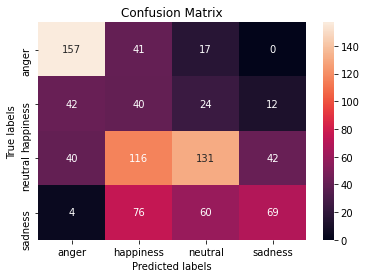


 Classification Report 
               precision    recall  f1-score   support

       anger       0.65      0.73      0.69       215
   happiness       0.15      0.34      0.20       118
     neutral       0.56      0.40      0.47       329
     sadness       0.56      0.33      0.42       209

    accuracy                           0.46       871
   macro avg       0.48      0.45      0.44       871
weighted avg       0.53      0.46      0.47       871
 

Train Epoch: 42 [0/3482 (0%)]	Loss: 1.111989

Train Epoch: 42 [640/3482 (18%)]	Loss: 0.949425

Train Epoch: 42 [1280/3482 (36%)]	Loss: 1.106523

Train Epoch: 42 [1920/3482 (55%)]	Loss: 1.107580

Train Epoch: 42 [2560/3482 (73%)]	Loss: 1.135750

Train Epoch: 42 [3200/3482 (91%)]	Loss: 1.010089


Train set: Average loss: 0.0168


Train Accuracy: 1860/3482 (53%)


Test set: Average loss: 0.0198, Accuracy: 421/871 (48%)



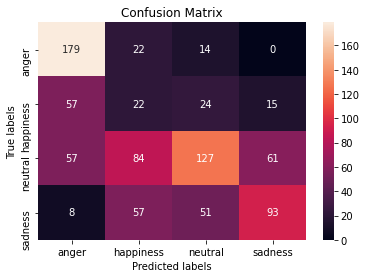


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.83      0.69       215
   happiness       0.12      0.19      0.15       118
     neutral       0.59      0.39      0.47       329
     sadness       0.55      0.44      0.49       209

    accuracy                           0.48       871
   macro avg       0.46      0.46      0.45       871
weighted avg       0.52      0.48      0.49       871
 

Train Epoch: 43 [0/3482 (0%)]	Loss: 1.006694

Train Epoch: 43 [640/3482 (18%)]	Loss: 1.037480

Train Epoch: 43 [1280/3482 (36%)]	Loss: 0.956944

Train Epoch: 43 [1920/3482 (55%)]	Loss: 1.016711

Train Epoch: 43 [2560/3482 (73%)]	Loss: 1.048730

Train Epoch: 43 [3200/3482 (91%)]	Loss: 1.137850


Train set: Average loss: 0.0169


Train Accuracy: 1913/3482 (55%)


Test set: Average loss: 0.0195, Accuracy: 437/871 (50%)



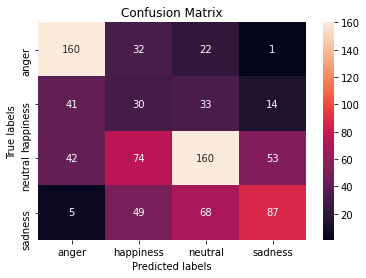


 Classification Report 
               precision    recall  f1-score   support

       anger       0.65      0.74      0.69       215
   happiness       0.16      0.25      0.20       118
     neutral       0.57      0.49      0.52       329
     sadness       0.56      0.42      0.48       209

    accuracy                           0.50       871
   macro avg       0.48      0.48      0.47       871
weighted avg       0.53      0.50      0.51       871
 

Train Epoch: 44 [0/3482 (0%)]	Loss: 1.199703

Train Epoch: 44 [640/3482 (18%)]	Loss: 1.120845

Train Epoch: 44 [1280/3482 (36%)]	Loss: 1.140171

Train Epoch: 44 [1920/3482 (55%)]	Loss: 0.959457

Train Epoch: 44 [2560/3482 (73%)]	Loss: 0.962214

Train Epoch: 44 [3200/3482 (91%)]	Loss: 0.990487


Train set: Average loss: 0.0168


Train Accuracy: 1845/3482 (53%)


Test set: Average loss: 0.0198, Accuracy: 414/871 (48%)



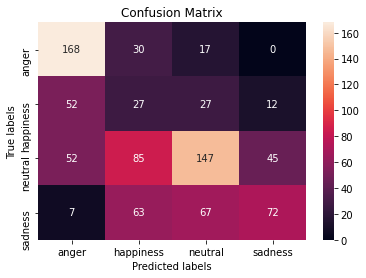


 Classification Report 
               precision    recall  f1-score   support

       anger       0.60      0.78      0.68       215
   happiness       0.13      0.23      0.17       118
     neutral       0.57      0.45      0.50       329
     sadness       0.56      0.34      0.43       209

    accuracy                           0.48       871
   macro avg       0.47      0.45      0.44       871
weighted avg       0.52      0.48      0.48       871
 

Train Epoch: 45 [0/3482 (0%)]	Loss: 1.118276

Train Epoch: 45 [640/3482 (18%)]	Loss: 1.064042

Train Epoch: 45 [1280/3482 (36%)]	Loss: 0.995381

Train Epoch: 45 [1920/3482 (55%)]	Loss: 1.007483

Train Epoch: 45 [2560/3482 (73%)]	Loss: 0.997076

Train Epoch: 45 [3200/3482 (91%)]	Loss: 1.020476


Train set: Average loss: 0.0170


Train Accuracy: 1899/3482 (55%)


Test set: Average loss: 0.0205, Accuracy: 350/871 (40%)



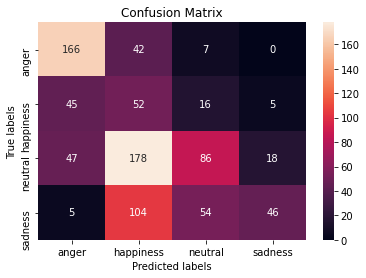


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.77      0.69       215
   happiness       0.14      0.44      0.21       118
     neutral       0.53      0.26      0.35       329
     sadness       0.67      0.22      0.33       209

    accuracy                           0.40       871
   macro avg       0.49      0.42      0.40       871
weighted avg       0.53      0.40      0.41       871
 

Train Epoch: 46 [0/3482 (0%)]	Loss: 1.125872

Train Epoch: 46 [640/3482 (18%)]	Loss: 0.999017

Train Epoch: 46 [1280/3482 (36%)]	Loss: 1.004589

Train Epoch: 46 [1920/3482 (55%)]	Loss: 1.092663

Train Epoch: 46 [2560/3482 (73%)]	Loss: 1.188508

Train Epoch: 46 [3200/3482 (91%)]	Loss: 1.082500


Train set: Average loss: 0.0168


Train Accuracy: 1877/3482 (54%)


Test set: Average loss: 0.0203, Accuracy: 369/871 (42%)



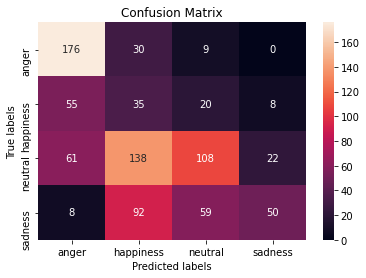


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.82      0.68       215
   happiness       0.12      0.30      0.17       118
     neutral       0.55      0.33      0.41       329
     sadness       0.62      0.24      0.35       209

    accuracy                           0.42       871
   macro avg       0.47      0.42      0.40       871
weighted avg       0.52      0.42      0.43       871
 

Train Epoch: 47 [0/3482 (0%)]	Loss: 1.215485

Train Epoch: 47 [640/3482 (18%)]	Loss: 0.960115

Train Epoch: 47 [1280/3482 (36%)]	Loss: 1.153817

Train Epoch: 47 [1920/3482 (55%)]	Loss: 0.941546

Train Epoch: 47 [2560/3482 (73%)]	Loss: 1.038054

Train Epoch: 47 [3200/3482 (91%)]	Loss: 1.046864


Train set: Average loss: 0.0168


Train Accuracy: 1903/3482 (55%)


Test set: Average loss: 0.0200, Accuracy: 402/871 (46%)



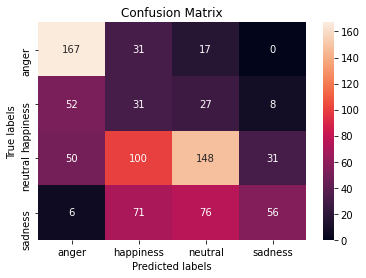


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.78      0.68       215
   happiness       0.13      0.26      0.18       118
     neutral       0.55      0.45      0.50       329
     sadness       0.59      0.27      0.37       209

    accuracy                           0.46       871
   macro avg       0.47      0.44      0.43       871
weighted avg       0.52      0.46      0.47       871
 

Train Epoch: 48 [0/3482 (0%)]	Loss: 0.880963

Train Epoch: 48 [640/3482 (18%)]	Loss: 1.038264

Train Epoch: 48 [1280/3482 (36%)]	Loss: 1.096979

Train Epoch: 48 [1920/3482 (55%)]	Loss: 1.254689

Train Epoch: 48 [2560/3482 (73%)]	Loss: 1.112607

Train Epoch: 48 [3200/3482 (91%)]	Loss: 0.989641


Train set: Average loss: 0.0168


Train Accuracy: 1849/3482 (53%)


Test set: Average loss: 0.0203, Accuracy: 377/871 (43%)



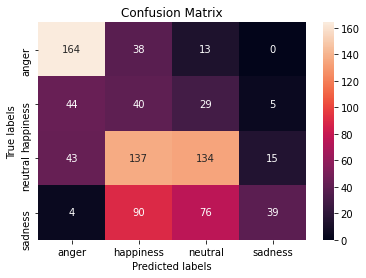


 Classification Report 
               precision    recall  f1-score   support

       anger       0.64      0.76      0.70       215
   happiness       0.13      0.34      0.19       118
     neutral       0.53      0.41      0.46       329
     sadness       0.66      0.19      0.29       209

    accuracy                           0.43       871
   macro avg       0.49      0.42      0.41       871
weighted avg       0.54      0.43      0.44       871
 

Train Epoch: 49 [0/3482 (0%)]	Loss: 0.922984

Train Epoch: 49 [640/3482 (18%)]	Loss: 0.944172

Train Epoch: 49 [1280/3482 (36%)]	Loss: 1.016710

Train Epoch: 49 [1920/3482 (55%)]	Loss: 1.074899

Train Epoch: 49 [2560/3482 (73%)]	Loss: 1.175034

Train Epoch: 49 [3200/3482 (91%)]	Loss: 1.039367


Train set: Average loss: 0.0168


Train Accuracy: 1905/3482 (55%)


Test set: Average loss: 0.0203, Accuracy: 383/871 (44%)



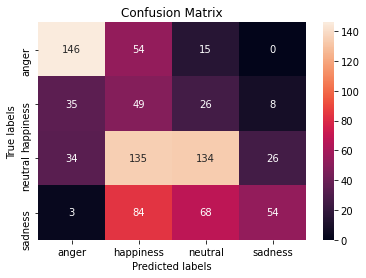


 Classification Report 
               precision    recall  f1-score   support

       anger       0.67      0.68      0.67       215
   happiness       0.15      0.42      0.22       118
     neutral       0.55      0.41      0.47       329
     sadness       0.61      0.26      0.36       209

    accuracy                           0.44       871
   macro avg       0.50      0.44      0.43       871
weighted avg       0.54      0.44      0.46       871
 

Train Epoch: 50 [0/3482 (0%)]	Loss: 1.027875

Train Epoch: 50 [640/3482 (18%)]	Loss: 1.078857

Train Epoch: 50 [1280/3482 (36%)]	Loss: 0.919419

Train Epoch: 50 [1920/3482 (55%)]	Loss: 1.044924

Train Epoch: 50 [2560/3482 (73%)]	Loss: 1.200729

Train Epoch: 50 [3200/3482 (91%)]	Loss: 1.224134


Train set: Average loss: 0.0169


Train Accuracy: 1915/3482 (55%)


Test set: Average loss: 0.0208, Accuracy: 331/871 (38%)



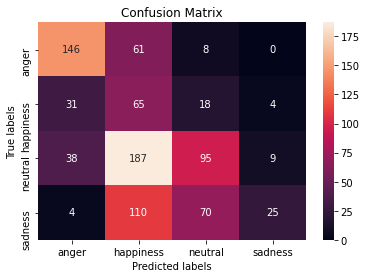


 Classification Report 
               precision    recall  f1-score   support

       anger       0.67      0.68      0.67       215
   happiness       0.15      0.55      0.24       118
     neutral       0.50      0.29      0.37       329
     sadness       0.66      0.12      0.20       209

    accuracy                           0.38       871
   macro avg       0.49      0.41      0.37       871
weighted avg       0.53      0.38      0.39       871
 

Train Epoch: 51 [0/3482 (0%)]	Loss: 1.102917

Train Epoch: 51 [640/3482 (18%)]	Loss: 1.060894

Train Epoch: 51 [1280/3482 (36%)]	Loss: 1.002651

Train Epoch: 51 [1920/3482 (55%)]	Loss: 1.166640

Train Epoch: 51 [2560/3482 (73%)]	Loss: 0.984095

Train Epoch: 51 [3200/3482 (91%)]	Loss: 1.100867


Train set: Average loss: 0.0168


Train Accuracy: 1891/3482 (54%)


Test set: Average loss: 0.0203, Accuracy: 378/871 (43%)



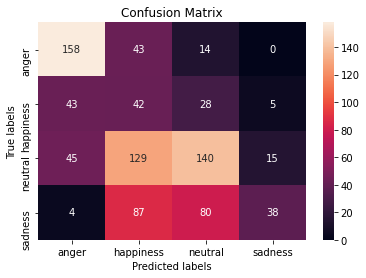


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.73      0.68       215
   happiness       0.14      0.36      0.20       118
     neutral       0.53      0.43      0.47       329
     sadness       0.66      0.18      0.28       209

    accuracy                           0.43       871
   macro avg       0.49      0.42      0.41       871
weighted avg       0.53      0.43      0.44       871
 

Train Epoch: 52 [0/3482 (0%)]	Loss: 1.057492

Train Epoch: 52 [640/3482 (18%)]	Loss: 1.230287

Train Epoch: 52 [1280/3482 (36%)]	Loss: 0.974846

Train Epoch: 52 [1920/3482 (55%)]	Loss: 1.076617

Train Epoch: 52 [2560/3482 (73%)]	Loss: 1.089637

Train Epoch: 52 [3200/3482 (91%)]	Loss: 1.175067


Train set: Average loss: 0.0169


Train Accuracy: 1886/3482 (54%)


Test set: Average loss: 0.0206, Accuracy: 343/871 (39%)



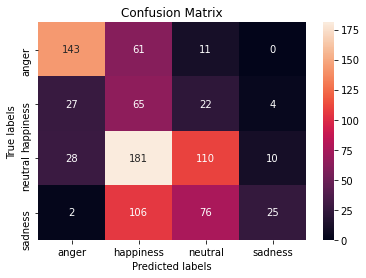


 Classification Report 
               precision    recall  f1-score   support

       anger       0.71      0.67      0.69       215
   happiness       0.16      0.55      0.24       118
     neutral       0.50      0.33      0.40       329
     sadness       0.64      0.12      0.20       209

    accuracy                           0.39       871
   macro avg       0.50      0.42      0.38       871
weighted avg       0.54      0.39      0.40       871
 

Train Epoch: 53 [0/3482 (0%)]	Loss: 1.040229

Train Epoch: 53 [640/3482 (18%)]	Loss: 0.995642

Train Epoch: 53 [1280/3482 (36%)]	Loss: 1.019549

Train Epoch: 53 [1920/3482 (55%)]	Loss: 1.012308

Train Epoch: 53 [2560/3482 (73%)]	Loss: 0.888173

Train Epoch: 53 [3200/3482 (91%)]	Loss: 1.149395


Train set: Average loss: 0.0168


Train Accuracy: 1905/3482 (55%)


Test set: Average loss: 0.0204, Accuracy: 359/871 (41%)



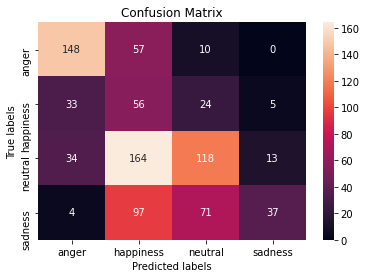


 Classification Report 
               precision    recall  f1-score   support

       anger       0.68      0.69      0.68       215
   happiness       0.15      0.47      0.23       118
     neutral       0.53      0.36      0.43       329
     sadness       0.67      0.18      0.28       209

    accuracy                           0.41       871
   macro avg       0.51      0.42      0.40       871
weighted avg       0.55      0.41      0.43       871
 

Train Epoch: 54 [0/3482 (0%)]	Loss: 1.119615

Train Epoch: 54 [640/3482 (18%)]	Loss: 1.005532

Train Epoch: 54 [1280/3482 (36%)]	Loss: 1.026888

Train Epoch: 54 [1920/3482 (55%)]	Loss: 1.046311

Train Epoch: 54 [2560/3482 (73%)]	Loss: 0.890589

Train Epoch: 54 [3200/3482 (91%)]	Loss: 1.154331


Train set: Average loss: 0.0168


Train Accuracy: 1914/3482 (55%)


Test set: Average loss: 0.0208, Accuracy: 319/871 (37%)



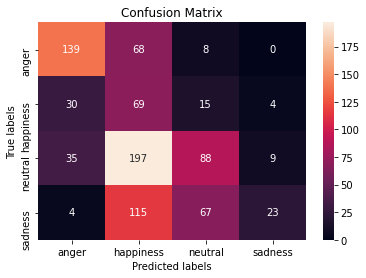


 Classification Report 
               precision    recall  f1-score   support

       anger       0.67      0.65      0.66       215
   happiness       0.15      0.58      0.24       118
     neutral       0.49      0.27      0.35       329
     sadness       0.64      0.11      0.19       209

    accuracy                           0.37       871
   macro avg       0.49      0.40      0.36       871
weighted avg       0.53      0.37      0.37       871
 

Train Epoch: 55 [0/3482 (0%)]	Loss: 1.025897

Train Epoch: 55 [640/3482 (18%)]	Loss: 1.087656

Train Epoch: 55 [1280/3482 (36%)]	Loss: 1.114859

Train Epoch: 55 [1920/3482 (55%)]	Loss: 0.950364

Train Epoch: 55 [2560/3482 (73%)]	Loss: 1.262417

Train Epoch: 55 [3200/3482 (91%)]	Loss: 0.987024


Train set: Average loss: 0.0166


Train Accuracy: 1877/3482 (54%)


Test set: Average loss: 0.0203, Accuracy: 362/871 (42%)



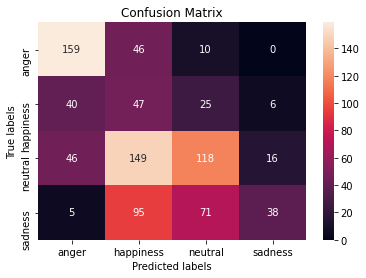


 Classification Report 
               precision    recall  f1-score   support

       anger       0.64      0.74      0.68       215
   happiness       0.14      0.40      0.21       118
     neutral       0.53      0.36      0.43       329
     sadness       0.63      0.18      0.28       209

    accuracy                           0.42       871
   macro avg       0.48      0.42      0.40       871
weighted avg       0.53      0.42      0.43       871
 

Train Epoch: 56 [0/3482 (0%)]	Loss: 0.887626

Train Epoch: 56 [640/3482 (18%)]	Loss: 1.072432

Train Epoch: 56 [1280/3482 (36%)]	Loss: 1.274224

Train Epoch: 56 [1920/3482 (55%)]	Loss: 0.979299

Train Epoch: 56 [2560/3482 (73%)]	Loss: 1.155965

Train Epoch: 56 [3200/3482 (91%)]	Loss: 1.157464


Train set: Average loss: 0.0166


Train Accuracy: 1913/3482 (55%)


Test set: Average loss: 0.0205, Accuracy: 363/871 (42%)



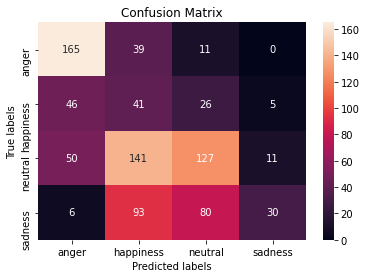


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.77      0.68       215
   happiness       0.13      0.35      0.19       118
     neutral       0.52      0.39      0.44       329
     sadness       0.65      0.14      0.24       209

    accuracy                           0.42       871
   macro avg       0.48      0.41      0.39       871
weighted avg       0.52      0.42      0.42       871
 

Train Epoch: 57 [0/3482 (0%)]	Loss: 1.120829

Train Epoch: 57 [640/3482 (18%)]	Loss: 1.254824

Train Epoch: 57 [1280/3482 (36%)]	Loss: 1.067834

Train Epoch: 57 [1920/3482 (55%)]	Loss: 0.951516

Train Epoch: 57 [2560/3482 (73%)]	Loss: 0.972698

Train Epoch: 57 [3200/3482 (91%)]	Loss: 1.070619


Train set: Average loss: 0.0166


Train Accuracy: 1924/3482 (55%)


Test set: Average loss: 0.0202, Accuracy: 357/871 (41%)



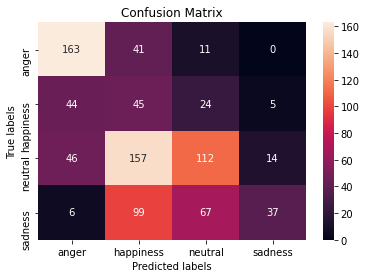


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.76      0.69       215
   happiness       0.13      0.38      0.20       118
     neutral       0.52      0.34      0.41       329
     sadness       0.66      0.18      0.28       209

    accuracy                           0.41       871
   macro avg       0.49      0.41      0.39       871
weighted avg       0.53      0.41      0.42       871
 

Train Epoch: 58 [0/3482 (0%)]	Loss: 0.971187

Train Epoch: 58 [640/3482 (18%)]	Loss: 1.231154

Train Epoch: 58 [1280/3482 (36%)]	Loss: 1.037718

Train Epoch: 58 [1920/3482 (55%)]	Loss: 1.092964

Train Epoch: 58 [2560/3482 (73%)]	Loss: 1.197972

Train Epoch: 58 [3200/3482 (91%)]	Loss: 1.038703


Train set: Average loss: 0.0166


Train Accuracy: 1891/3482 (54%)


Test set: Average loss: 0.0201, Accuracy: 397/871 (46%)



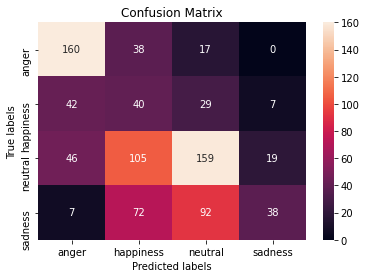


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.74      0.68       215
   happiness       0.16      0.34      0.21       118
     neutral       0.54      0.48      0.51       329
     sadness       0.59      0.18      0.28       209

    accuracy                           0.46       871
   macro avg       0.48      0.44      0.42       871
weighted avg       0.52      0.46      0.46       871
 

Train Epoch: 59 [0/3482 (0%)]	Loss: 1.080237

Train Epoch: 59 [640/3482 (18%)]	Loss: 0.872707

Train Epoch: 59 [1280/3482 (36%)]	Loss: 1.131619

Train Epoch: 59 [1920/3482 (55%)]	Loss: 1.296962

Train Epoch: 59 [2560/3482 (73%)]	Loss: 1.232217

Train Epoch: 59 [3200/3482 (91%)]	Loss: 0.998108


Train set: Average loss: 0.0166


Train Accuracy: 1902/3482 (55%)


Test set: Average loss: 0.0203, Accuracy: 363/871 (42%)



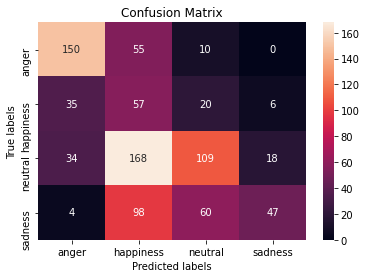


 Classification Report 
               precision    recall  f1-score   support

       anger       0.67      0.70      0.68       215
   happiness       0.15      0.48      0.23       118
     neutral       0.55      0.33      0.41       329
     sadness       0.66      0.22      0.34       209

    accuracy                           0.42       871
   macro avg       0.51      0.43      0.42       871
weighted avg       0.55      0.42      0.44       871
 

Train Epoch: 60 [0/3482 (0%)]	Loss: 1.231737

Train Epoch: 60 [640/3482 (18%)]	Loss: 0.965264

Train Epoch: 60 [1280/3482 (36%)]	Loss: 1.061970

Train Epoch: 60 [1920/3482 (55%)]	Loss: 1.168491

Train Epoch: 60 [2560/3482 (73%)]	Loss: 1.006647

Train Epoch: 60 [3200/3482 (91%)]	Loss: 0.960971


Train set: Average loss: 0.0168


Train Accuracy: 1883/3482 (54%)


Test set: Average loss: 0.0202, Accuracy: 380/871 (44%)



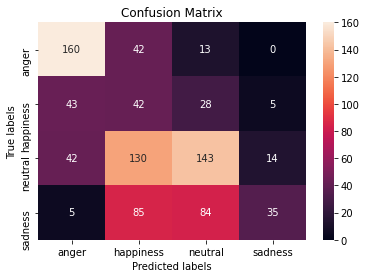


 Classification Report 
               precision    recall  f1-score   support

       anger       0.64      0.74      0.69       215
   happiness       0.14      0.36      0.20       118
     neutral       0.53      0.43      0.48       329
     sadness       0.65      0.17      0.27       209

    accuracy                           0.44       871
   macro avg       0.49      0.43      0.41       871
weighted avg       0.53      0.44      0.44       871
 



In [39]:
history = []
n_epoch = 61
for epoch in range(1, n_epoch):
#     exp_lr_scheduler.step(epoch)
    
    train_loss, train_acc = train(epoch, model)
    
    test_loss, test_acc = test(model)
    
#     plateau_scheduler.step(test_loss)
    
    history.append([train_loss, train_acc, test_loss, test_acc])

In [40]:
history_df = pd.DataFrame(history, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [41]:
history_df["epoch"] = [x for x in range(1, n_epoch)]

In [42]:
history_df

train_loss  train_acc  test_loss  test_acc  epoch
0     0.023200         25   0.022400        22      1
1     0.021842         28   0.022293        23      2
2     0.021708         30   0.022248        23      3
3     0.021440         32   0.022141        23      4
4     0.021132         35   0.021957        24      5
5     0.020588         37   0.021722        27      6
6     0.020090         40   0.021389        30      7
7     0.019651         41   0.021162        32      8
8     0.019248         43   0.021076        34      9
9     0.018950         44   0.020643        40     10
10    0.018879         45   0.020500        40     11
11    0.018679         44   0.020408        45     12
12    0.018414         47   0.020351        45     13
13    0.018190         48   0.019955        45     14
14    0.018091         48   0.020056        49     15
15    0.017849         49   0.019809        49     16
16    0.017788         49   0.019860        50     17
17    0.017744         49   0.019869        52     18
18    0.017791         50   0.019924        50     19
19    0.017406         49   0.019556        53     20
20    0.017425         51   0.019350        52     21
21    0.017351         51   0.019797        51     22
22    0.017366         51   0.019512        52     23
23    0.017366         52   0.019635        51     24
24    0.017242         51   0.019553        50     25
25    0.017288         51   0.019466        51     26
26    0.017078         53   0.019539        51     27
27    0.017149         52   0.019747        49     28
28    0.017146         52   0.019689        50     29
29    0.016943         52   0.019337        49     30
30    0.017017         53   0.019264        52     31
31    0.016891         53   0.019359        50     32
32    0.016989         52   0.020001        45     33
33    0.017029         53   0.019844        48     34
34    0.016938         53   0.019603        49     35
35    0.017003         53   0.019949        47     36
36    0.016955         54   0.020134        44     37
37    0.017015         53   0.019926        48     38
38    0.016847         52   0.019546        49     39
39    0.016917         54   0.020126        44     40
40    0.016955         53   0.020186        45     41
41    0.016830         53   0.019770        48     42
42    0.016858         54   0.019476        50     43
43    0.016819         52   0.019824        47     44
44    0.016961         54   0.020469        40     45
45    0.016830         53   0.020321        42     46
46    0.016836         54   0.020044        46     47
47    0.016793         53   0.020350        43     48
48    0.016797         54   0.020305        43     49
49    0.016856         54   0.020820        38     50
50    0.016774         54   0.020324        43     51
51    0.016852         54   0.020619        39     52
52    0.016787         54   0.020394        41     53
53    0.016757         54   0.020849        36     54
54    0.016605         53   0.020330        41     55
55    0.016599         54   0.020470        41     56
56    0.016631         55   0.020247        40     57
57    0.016613         54   0.020073        45     58
58    0.016632         54   0.020325        41     59
59    0.016772         54   0.020209        43     60

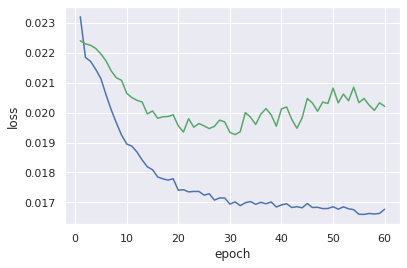

In [43]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_df, color='b')
# plt.xticks(history_df.epoch)
sns.lineplot(x='epoch', y='test_loss', data=history_df, color='g')
plt.ylabel("loss")
plt.show()

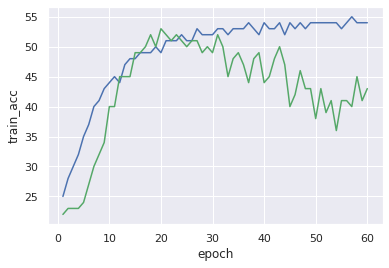

In [44]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_df, color='b')
# plt.xticks(history_df.epoch)
sns.lineplot(x='epoch', y='test_acc', data=history_df, color='g')
plt.show()

In [45]:
torch.save(model, model_save_path + '/CNN_unfreeze.pth')

In [46]:
model = torch.load(model_save_path + '/CNN_unfreeze.pth')

In [47]:
for param in model.parameters():
    param.requires_grad = False

In [48]:
ct = 0
for child in model.children():
    ct += 1
#     print(ct)
    if ct > 3:
        print("child", ct, "was not frozen")
        for param in child.parameters():
            param.requires_grad = True
    else:
        print("child", ct, "was frozen")

child 1 was frozen
child 2 was frozen
child 3 was frozen
child 4 was not frozen
child 5 was not frozen
child 6 was not frozen
child 7 was not frozen


In [49]:
# for param in model.parameters():
#     param.requires_grad = True
# optimizer = optim.Adam(model.parameters(), lr=0.003)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [50]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

1,632,820 total parameters.
1,609,236 training parameters.


In [51]:
model = model.to(device)

Train Epoch: 1 [0/3482 (0%)]	Loss: 1.090411

Train Epoch: 1 [640/3482 (18%)]	Loss: 1.070462

Train Epoch: 1 [1280/3482 (36%)]	Loss: 1.016881

Train Epoch: 1 [1920/3482 (55%)]	Loss: 1.055825

Train Epoch: 1 [2560/3482 (73%)]	Loss: 1.203361

Train Epoch: 1 [3200/3482 (91%)]	Loss: 1.073014


Train set: Average loss: 0.0166


Train Accuracy: 1937/3482 (56%)


Test set: Average loss: 0.0202, Accuracy: 378/871 (43%)



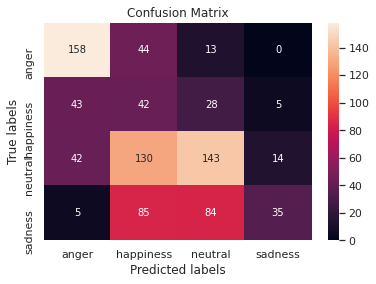


 Classification Report 
               precision    recall  f1-score   support

       anger       0.64      0.73      0.68       215
   happiness       0.14      0.36      0.20       118
     neutral       0.53      0.43      0.48       329
     sadness       0.65      0.17      0.27       209

    accuracy                           0.43       871
   macro avg       0.49      0.42      0.41       871
weighted avg       0.53      0.43      0.44       871
 

Train Epoch: 2 [0/3482 (0%)]	Loss: 1.009183

Train Epoch: 2 [640/3482 (18%)]	Loss: 1.054736

Train Epoch: 2 [1280/3482 (36%)]	Loss: 0.998545

Train Epoch: 2 [1920/3482 (55%)]	Loss: 1.078141

Train Epoch: 2 [2560/3482 (73%)]	Loss: 0.875704

Train Epoch: 2 [3200/3482 (91%)]	Loss: 1.022787


Train set: Average loss: 0.0166


Train Accuracy: 1888/3482 (54%)


Test set: Average loss: 0.0202, Accuracy: 377/871 (43%)



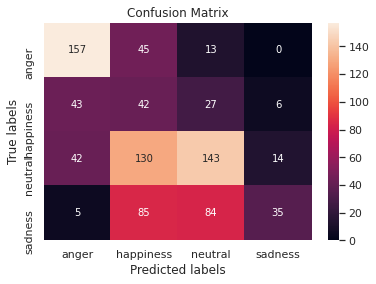


 Classification Report 
               precision    recall  f1-score   support

       anger       0.64      0.73      0.68       215
   happiness       0.14      0.36      0.20       118
     neutral       0.54      0.43      0.48       329
     sadness       0.64      0.17      0.27       209

    accuracy                           0.43       871
   macro avg       0.49      0.42      0.41       871
weighted avg       0.53      0.43      0.44       871
 

Train Epoch: 3 [0/3482 (0%)]	Loss: 1.095151

Train Epoch: 3 [640/3482 (18%)]	Loss: 1.060130

Train Epoch: 3 [1280/3482 (36%)]	Loss: 1.083326

Train Epoch: 3 [1920/3482 (55%)]	Loss: 0.975174

Train Epoch: 3 [2560/3482 (73%)]	Loss: 1.148559

Train Epoch: 3 [3200/3482 (91%)]	Loss: 0.977544


Train set: Average loss: 0.0167


Train Accuracy: 1929/3482 (55%)


Test set: Average loss: 0.0202, Accuracy: 378/871 (43%)



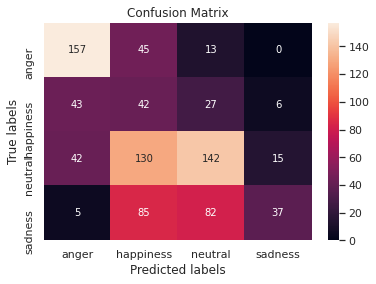


 Classification Report 
               precision    recall  f1-score   support

       anger       0.64      0.73      0.68       215
   happiness       0.14      0.36      0.20       118
     neutral       0.54      0.43      0.48       329
     sadness       0.64      0.18      0.28       209

    accuracy                           0.43       871
   macro avg       0.49      0.42      0.41       871
weighted avg       0.53      0.43      0.44       871
 

Train Epoch: 4 [0/3482 (0%)]	Loss: 0.962225

Train Epoch: 4 [640/3482 (18%)]	Loss: 1.025573

Train Epoch: 4 [1280/3482 (36%)]	Loss: 0.978955

Train Epoch: 4 [1920/3482 (55%)]	Loss: 1.211510

Train Epoch: 4 [2560/3482 (73%)]	Loss: 1.096030

Train Epoch: 4 [3200/3482 (91%)]	Loss: 1.042681


Train set: Average loss: 0.0166


Train Accuracy: 1929/3482 (55%)


Test set: Average loss: 0.0202, Accuracy: 377/871 (43%)



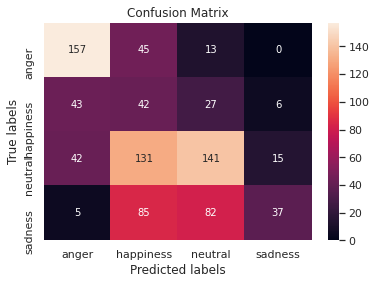


 Classification Report 
               precision    recall  f1-score   support

       anger       0.64      0.73      0.68       215
   happiness       0.14      0.36      0.20       118
     neutral       0.54      0.43      0.48       329
     sadness       0.64      0.18      0.28       209

    accuracy                           0.43       871
   macro avg       0.49      0.42      0.41       871
weighted avg       0.53      0.43      0.44       871
 

Train Epoch: 5 [0/3482 (0%)]	Loss: 1.032415

Train Epoch: 5 [640/3482 (18%)]	Loss: 1.119124

Train Epoch: 5 [1280/3482 (36%)]	Loss: 1.260549

Train Epoch: 5 [1920/3482 (55%)]	Loss: 0.894658

Train Epoch: 5 [2560/3482 (73%)]	Loss: 1.042457

Train Epoch: 5 [3200/3482 (91%)]	Loss: 1.075204


Train set: Average loss: 0.0168


Train Accuracy: 1915/3482 (55%)


Test set: Average loss: 0.0202, Accuracy: 379/871 (44%)



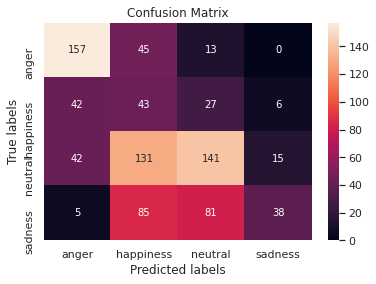


 Classification Report 
               precision    recall  f1-score   support

       anger       0.64      0.73      0.68       215
   happiness       0.14      0.36      0.20       118
     neutral       0.54      0.43      0.48       329
     sadness       0.64      0.18      0.28       209

    accuracy                           0.44       871
   macro avg       0.49      0.43      0.41       871
weighted avg       0.53      0.44      0.44       871
 



In [52]:
history_unfreeze = []
n_epoch_unfrz = 6
for epoch in range(1, n_epoch_unfrz):
#     exp_lr_scheduler.step(epoch)
    
    train_loss, train_acc = train(epoch, model)
    
    test_loss, test_acc = test(model)
    
    history_unfreeze.append([train_loss, train_acc, test_loss, test_acc])

In [53]:
history_df_unfrz = pd.DataFrame(history_unfreeze, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [54]:
history_df_unfrz["epoch"] = [x for x in range(n_epoch, n_epoch + n_epoch_unfrz - 1)]

In [55]:
history_df_unfrz

train_loss  train_acc  test_loss  test_acc  epoch
0    0.016590         55   0.020206        43     61
1    0.016630         54   0.020203        43     62
2    0.016719         55   0.020200        43     63
3    0.016598         55   0.020197        43     64
4    0.016752         54   0.020195        43     65

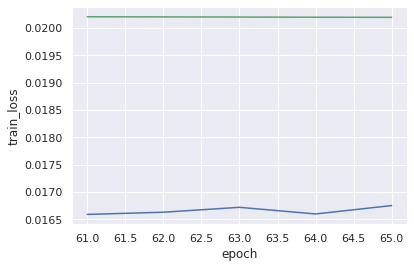

In [56]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_df_unfrz, color='b')
sns.lineplot(x='epoch', y='test_loss', data=history_df_unfrz, color='g')
plt.show()
# plt.xticks()

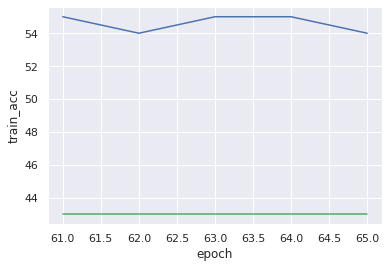

In [57]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_df_unfrz, color='b')
sns.lineplot(x='epoch', y='test_acc', data=history_df_unfrz, color='g')
plt.show()
# plt.xticks()

In [58]:
torch.save(model, model_save_path + '/ResNet34_UnFreeze_Weights.pth')

In [59]:
history_total = pd.concat([history_df, history_df_unfrz])

In [60]:
history_total

train_loss  train_acc  test_loss  test_acc  epoch
0     0.023200         25   0.022400        22      1
1     0.021842         28   0.022293        23      2
2     0.021708         30   0.022248        23      3
3     0.021440         32   0.022141        23      4
4     0.021132         35   0.021957        24      5
..         ...        ...        ...       ...    ...
0     0.016590         55   0.020206        43     61
1     0.016630         54   0.020203        43     62
2     0.016719         55   0.020200        43     63
3     0.016598         55   0.020197        43     64
4     0.016752         54   0.020195        43     65

[65 rows x 5 columns]

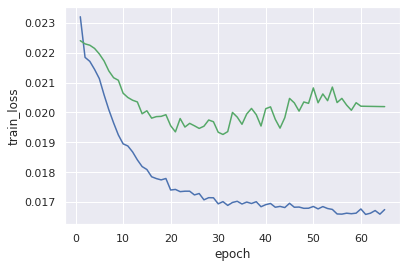

In [61]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_total, color='b')
sns.lineplot(x='epoch', y='test_loss', data=history_total, color='g')
plt.show()
# plt.xticks()

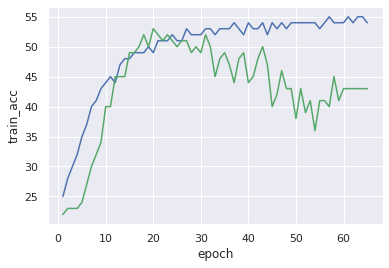

In [62]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_total, color='b')
sns.lineplot(x='epoch', y='test_acc', data=history_total, color='g')
plt.show()
# plt.xticks()

In [1]:
from __future__ import print_function
import numpy as np 
import pandas as pd 
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import IPython.display as ipd
import seaborn as sns

import warnings
import os
warnings.filterwarnings('ignore')

from torch import nn, optim
from torchvision import transforms, models, datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
data_dir = '/content/drive/MyDrive/spectrograms'
model_save_path = '/content/drive/MyDrive/saved_models'
train_dir = data_dir + '/Train'
test_dir = data_dir + '/Test'